In [1]:
# Importer les librairies indispensables
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns
import os
import time  # Importer la bibliothèque time
import tensorflow as tf
import cv2
import warnings
warnings.filterwarnings('ignore')

from scipy.fftpack import dct

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc ,roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay



from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, TimeDistributed, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping


from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier


from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy import signal

from prettytable import PrettyTable

from sklearn.utils.class_weight import compute_class_weight



## COLLECTE DES DONNEES

In [2]:
# Chemin du fichier CSV
file_path = 'solicited_combined_database.csv'

# Lire le fichier CSV
csv = pd.read_csv(file_path)

# Afficher les premières lignes du DataFrame
csv.head()

,participant,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,...,type,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,filename,sound_prediction_score,sample_rate
0,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,train,UG,18,Negative,Negative,Negative,NaN,1645088710003-recording-1.wav,0.990254,44100
1,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,train,UG,18,Negative,Negative,Negative,NaN,1645088760390-recording-1.wav,0.990272,44100
2,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,train,UG,18,Negative,Negative,Negative,NaN,1645088760830-recording-1.wav,0.990112,44100
3,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,train,UG,18,Negative,Negative,Negative,NaN,1645088710843-recording-1.wav,0.990152,44100
4,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,train,UG,18,Negative,Negative,Negative,NaN,1645088759950-recording-1.wav,0.990039,44100


In [3]:
csv.shape

(9772, 28)

## Fichier pickle

In [4]:
# Specify the path to your pickle file
pickle_file_path = 'solicited_combined_database.pkl'

# Load the DataFrame from the pickle file
combined_data = pd.read_pickle(pickle_file_path)

In [5]:
combined_data.head()

,participant,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,...,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,filename,sound_prediction_score,sample_rate,audio_signal
0,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088710003-recording-1.wav,0.990254,44100,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ..."
1,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088760390-recording-1.wav,0.990272,44100,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ..."
2,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088760830-recording-1.wav,0.990112,44100,"[-54, -41, -20, -10, -19, -8, 8, 27, 37, 53, 3..."
3,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088710843-recording-1.wav,0.990152,44100,"[-6, -36, -63, -71, -49, -14, -10, -9, -35, -2..."
4,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088759950-recording-1.wav,0.990039,44100,"[72, 37, 22, 53, 92, 98, 61, 42, 64, 58, 40, 4..."


In [6]:
combined_data.shape

(9772, 29)

## Filtre sur l'Inde uniquement

In [7]:
# Specify the path to your pickle file
pickle_file_path = 'solicited_combined_database.pkl'

# Load the DataFrame from the pickle file
combined_data = pd.read_pickle(pickle_file_path)

# Filter the DataFrame for Vietnam
combined_data = combined_data[combined_data['Country'] == 'UG']



## 2- EDA

In [8]:
combined_data

,participant,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,...,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,filename,sound_prediction_score,sample_rate,audio_signal
0,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088710003-recording-1.wav,0.990254,44100,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ..."
1,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088760390-recording-1.wav,0.990272,44100,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ..."
2,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088760830-recording-1.wav,0.990112,44100,"[-54, -41, -20, -10, -19, -8, 8, 27, 37, 53, 3..."
3,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088710843-recording-1.wav,0.990152,44100,"[-6, -36, -63, -71, -49, -14, -10, -9, -35, -2..."
4,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,UG,18,Negative,Negative,Negative,NaN,1645088759950-recording-1.wav,0.990039,44100,"[72, 37, 22, 53, 92, 98, 61, 42, 64, 58, 40, 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9731,CODA_TB_1103,Male,51,163.0,46.0,90,No,No,No,No,...,UG,6,Negative,Negative,Negative,NaN,1631098807256-recording-1.wav,0.865266,44100,"[-1337, -1604, -1586, -1455, -1429, -1497, -16..."
9732,CODA_TB_1103,Male,51,163.0,46.0,90,No,No,No,No,...,UG,6,Negative,Negative,Negative,NaN,1631098835911-recording-1.wav,0.978943,44100,"[-198, -122, -90, -96, -49, -62, -82, -136, -1..."
9733,CODA_TB_1103,Male,51,163.0,46.0,90,No,No,No,No,...,UG,6,Negative,Negative,Negative,NaN,1631098866428-recording-1.wav,0.965575,44100,"[1163, 1153, 1037, 824, 846, 825, 934, 1038, 1..."
9734,CODA_TB_1103,Male,51,163.0,46.0,90,No,No,No,No,...,UG,6,Negative,Negative,Negative,NaN,1631098867908-recording-1.wav,0.876146,44100,"[886, 1540, 1821, 1341, 645, -232, -764, -478,..."


In [9]:
combined_data.columns

Index(['participant', 'sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats', 'tb_status', 'type', 'Country',
       'Numberofcoughsoundscollected', 'HIVstatus',
       'Microbiologicreferencestandard', 'Sputumxpertreferencestandard',
       'Xpertcombinedsemiquant', 'filename', 'sound_prediction_score',
       'sample_rate', 'audio_signal'],
      dtype='object')

In [10]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 0 to 9735
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   participant                     2166 non-null   object 
 1   sex                             2166 non-null   object 
 2   age                             2166 non-null   int64  
 3   height                          2166 non-null   float64
 4   weight                          2166 non-null   float64
 5   reported_cough_dur              2166 non-null   int64  
 6   tb_prior                        2166 non-null   object 
 7   tb_prior_Pul                    2166 non-null   object 
 8   tb_prior_Extrapul               2166 non-null   object 
 9   tb_prior_Unknown                2166 non-null   object 
 10  hemoptysis                      2166 non-null   object 
 11  heart_rate                      2166 non-null   int64  
 12  temperature                     2166 no

In [11]:
combined_data['participant'].value_counts()

participant
CODA_TB_0197    41
CODA_TB_0665    37
CODA_TB_0540    29
CODA_TB_0549    26
CODA_TB_0792    26
                ..
CODA_TB_0281     3
CODA_TB_0992     3
CODA_TB_0683     3
CODA_TB_1010     3
CODA_TB_0559     3
Name: count, Length: 233, dtype: int64

In [12]:
combined_data['sex'].value_counts()

sex
Male      1215
Female     951
Name: count, dtype: int64

In [13]:
combined_data['age'].describe()

count    2166.000000
mean       35.300554
std        12.230718
min        18.000000
25%        26.000000
50%        33.000000
75%        42.000000
max        78.000000
Name: age, dtype: float64

In [14]:
combined_data['height'].describe()

count    2166.000000
mean      165.092752
std         8.241363
min       142.600000
25%       160.000000
50%       165.000000
75%       170.500000
max       198.000000
Name: height, dtype: float64

In [15]:
combined_data['weight'].describe()

count    2166.000000
mean       57.840905
std         9.515495
min        38.000000
25%        51.500000
50%        56.000000
75%        63.000000
max        87.000000
Name: weight, dtype: float64

In [16]:
combined_data['reported_cough_dur'].describe()

count    2166.000000
mean       47.445522
std        48.115839
min        14.000000
25%        14.000000
50%        30.000000
75%        60.000000
max       360.000000
Name: reported_cough_dur, dtype: float64

In [17]:
# Self reported. At baseline, we ask: Have you ever had or been told you had tuberculosis (TB)?
combined_data['tb_prior'].value_counts()

tb_prior
No     1836
Yes     330
Name: count, dtype: int64

In [18]:
# Asked at baseline: "With what kind of TB were you diagnosed?" (may select more than one)Participant selected pulmonary TB.
combined_data['tb_prior_Pul'].value_counts()

tb_prior_Pul
No     1843
Yes     323
Name: count, dtype: int64

In [19]:
# Asked at baseline: "With what kind of TB were you diagnosed?" (may select more than one) Participant selected extrapulmonary TB.
combined_data['tb_prior_Extrapul'].value_counts()

tb_prior_Extrapul
No     2159
Yes       7
Name: count, dtype: int64

In [20]:
# Asked at baseline: "With what kind of TB were you diagnosed?" (may select more than one) Participant selected Unknown.
combined_data['tb_prior_Unknown'].value_counts()

tb_prior_Unknown
No    2166
Name: count, dtype: int64

In [21]:
# In the past 30 days, have you ever coughed up blood?
combined_data['hemoptysis'].value_counts()

hemoptysis
No     1844
Yes     322
Name: count, dtype: int64

In [22]:
combined_data['heart_rate'].value_counts()

heart_rate
98     97
90     97
96     96
87     94
88     66
       ..
127     5
51      5
50      5
125     4
140     3
Name: count, Length: 74, dtype: int64

In [23]:
combined_data['temperature'].describe()

count    2166.000000
mean       36.852124
std         0.607408
min        35.900000
25%        36.500000
50%        36.800000
75%        37.000000
max        40.200000
Name: temperature, dtype: float64

In [24]:
combined_data['weight_loss'].value_counts()

weight_loss
Yes    1625
No      541
Name: count, dtype: int64

In [25]:
combined_data['smoke_lweek'].value_counts()

smoke_lweek
No     1944
Yes     222
Name: count, dtype: int64

In [26]:
combined_data['fever'].value_counts()

fever
Yes    1643
No      523
Name: count, dtype: int64

In [27]:
combined_data['night_sweats'].value_counts()

night_sweats
Yes    1614
No      552
Name: count, dtype: int64

In [28]:
combined_data['tb_status'].value_counts()

tb_status
0    1351
1     815
Name: count, dtype: int64

In [29]:
combined_data['type'].value_counts()  

type
train    2166
Name: count, dtype: int64

In [30]:
combined_data['Country'].value_counts()

Country
UG    2166
Name: count, dtype: int64

In [31]:
combined_data['Numberofcoughsoundscollected'].describe()

count    2166.000000
mean       13.559557
std         8.159264
min         3.000000
25%         7.000000
50%        12.000000
75%        18.000000
max        41.000000
Name: Numberofcoughsoundscollected, dtype: float64

In [32]:
combined_data['HIVstatus'].value_counts()

HIVstatus
Negative    1608
Positive     558
Name: count, dtype: int64

In [33]:
# 
combined_data['Microbiologicreferencestandard'].value_counts()

Microbiologicreferencestandard
Negative    1351
Positive     815
Name: count, dtype: int64

In [34]:
combined_data['Sputumxpertreferencestandard'].value_counts()

Sputumxpertreferencestandard
Negative    1405
Positive     761
Name: count, dtype: int64

In [35]:
combined_data['Xpertcombinedsemiquant'].value_counts()

Xpertcombinedsemiquant
High        275
Medium      214
Low         144
Very low    111
Trace        17
Name: count, dtype: int64

In [36]:
combined_data['filename'].value_counts()   

filename
1645088710003-recording-1.wav    1
1630318294762-recording-1.wav    1
1632389157776-recording-1.wav    1
1632389223896-recording-1.wav    1
1632389158896-recording-1.wav    1
                                ..
1648633212919-recording-1.wav    1
1648633183714-recording-1.wav    1
1648633181874-recording-1.wav    1
1648633155070-recording-1.wav    1
1631098868348-recording-1.wav    1
Name: count, Length: 2166, dtype: int64

In [37]:
combined_data['sound_prediction_score'].value_counts() 

sound_prediction_score
0.990293    4
0.990272    4
0.990254    3
0.989558    3
0.990264    3
           ..
0.982715    1
0.852566    1
0.946108    1
0.989402    1
0.882230    1
Name: count, Length: 2101, dtype: int64

In [38]:
combined_data['sample_rate'].value_counts() 

sample_rate
44100    2166
Name: count, dtype: int64

In [39]:
combined_data['sound_prediction_score'].describe()

count    2166.000000
mean        0.966281
std         0.035068
min         0.850547
25%         0.941017
50%         0.986091
75%         0.990264
max         1.000000
Name: sound_prediction_score, dtype: float64

In [40]:
# Supprimer des colonnes inutiles  'sample_rate', 'filename', 'type'
combined_data.drop(['sample_rate', 'filename', 'type'] , axis=1 , inplace= True)

In [41]:
combined_data.head(2)

,participant,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,...,night_sweats,tb_status,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,sound_prediction_score,audio_signal
0,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,Yes,0,UG,18,Negative,Negative,Negative,NaN,0.990254,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ..."
1,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,...,Yes,0,UG,18,Negative,Negative,Negative,NaN,0.990272,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ..."


In [42]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 0 to 9735
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   participant                     2166 non-null   object 
 1   sex                             2166 non-null   object 
 2   age                             2166 non-null   int64  
 3   height                          2166 non-null   float64
 4   weight                          2166 non-null   float64
 5   reported_cough_dur              2166 non-null   int64  
 6   tb_prior                        2166 non-null   object 
 7   tb_prior_Pul                    2166 non-null   object 
 8   tb_prior_Extrapul               2166 non-null   object 
 9   tb_prior_Unknown                2166 non-null   object 
 10  hemoptysis                      2166 non-null   object 
 11  heart_rate                      2166 non-null   int64  
 12  temperature                     2166 no

In [43]:
num_data = combined_data.select_dtypes(exclude = 'object')
cat_data = combined_data.select_dtypes(include = 'object')

In [44]:
num_data.columns

Index(['age', 'height', 'weight', 'reported_cough_dur', 'heart_rate',
       'temperature', 'tb_status', 'Numberofcoughsoundscollected',
       'sound_prediction_score'],
      dtype='object')

In [45]:
cat_data.columns

Index(['participant', 'sex', 'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul',
       'tb_prior_Unknown', 'hemoptysis', 'weight_loss', 'smoke_lweek', 'fever',
       'night_sweats', 'Country', 'HIVstatus',
       'Microbiologicreferencestandard', 'Sputumxpertreferencestandard',
       'Xpertcombinedsemiquant', 'audio_signal'],
      dtype='object')

In [46]:
#!pip install sounddevice

In [47]:
# import sounddevice as sd
# from scipy.io .wavfile import write
# sample_rate = 44100
# array = combined_data.loc[0,'audio_signal']
# array = array/np.max(np.abs(array))
# array_long = np.tile(array,10)
# sd.play(array_long,sample_rate)
# # array_int16 = np.int16(array*32767)
# # write('1645088710003-recording-1.wav',sample_rate,array_int16)


In [48]:
print(combined_data['tb_status'].dtype)
print(combined_data['tb_status'].unique())

int64
[0 1]


In [49]:
# combined_data['tb_status'] = pd.Categorical(combined_data['tb_status'])

In [50]:
# on transforme la variable cible en variable catégorielle nominale (true or false ,  0 ou 1)
#combined_data['tb_status'] = combined_data['tb_status'].astype('category')


In [51]:
# Afficher les statistiques descriptives globales
print("\nStatistiques descriptives globales:")
combined_data.describe().T


Statistiques descriptives globales:


,count,mean,std,min,25%,50%,75%,max
age,2166.0,35.300554,12.230718,18.000000,26.000000,33.000000,42.000000,78.0
height,2166.0,165.092752,8.241363,142.600000,160.000000,165.000000,170.500000,198.0
weight,2166.0,57.840905,9.515495,38.000000,51.500000,56.000000,63.000000,87.0
reported_cough_dur,2166.0,47.445522,48.115839,14.000000,14.000000,30.000000,60.000000,360.0
heart_rate,2166.0,90.487996,19.770942,50.000000,75.000000,90.000000,99.000000,153.0
temperature,2166.0,36.852124,0.607408,35.900000,36.500000,36.800000,37.000000,40.2
tb_status,2166.0,0.376270,0.484561,0.000000,0.000000,0.000000,1.000000,1.0
Numberofcoughsoundscollected,2166.0,13.559557,8.159264,3.000000,7.000000,12.000000,18.000000,41.0
sound_prediction_score,2166.0,0.966281,0.035068,0.850547,0.941017,0.986091,0.990264,1.0


In [52]:
# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne: Xpertcombinedsemiquant")
combined_data.isnull().sum()


Valeurs manquantes par colonne: Xpertcombinedsemiquant


participant                          0
sex                                  0
age                                  0
height                               0
weight                               0
reported_cough_dur                   0
tb_prior                             0
tb_prior_Pul                         0
tb_prior_Extrapul                    0
tb_prior_Unknown                     0
hemoptysis                           0
heart_rate                           0
temperature                          0
weight_loss                          0
smoke_lweek                          0
fever                                0
night_sweats                         0
tb_status                            0
Country                              0
Numberofcoughsoundscollected         0
HIVstatus                            0
Microbiologicreferencestandard       0
Sputumxpertreferencestandard         0
Xpertcombinedsemiquant            1405
sound_prediction_score               0
audio_signal             

### On remplace les valeurs manquantes par le mode pour les catégorielles et par la moyenne pour les numériques

In [53]:
# variables cat
#combined_data['HIVstatus'] = combined_data['HIVstatus'].fillna(combined_data['HIVstatus'].mode()[0])
#combined_data['Microbiologicreferencestandard'] = combined_data['Microbiologicreferencestandard'].fillna(combined_data['Microbiologicreferencestandard'].mode()[0])
combined_data['Xpertcombinedsemiquant'] = combined_data['Xpertcombinedsemiquant'].fillna(combined_data['Xpertcombinedsemiquant'].mode()[0])

# variable num
#combined_data['height'] = combined_data['height'].fillna(combined_data['height'].mean())

In [54]:
combined_data.isna().sum() 

participant                       0
sex                               0
age                               0
height                            0
weight                            0
reported_cough_dur                0
tb_prior                          0
tb_prior_Pul                      0
tb_prior_Extrapul                 0
tb_prior_Unknown                  0
hemoptysis                        0
heart_rate                        0
temperature                       0
weight_loss                       0
smoke_lweek                       0
fever                             0
night_sweats                      0
tb_status                         0
Country                           0
Numberofcoughsoundscollected      0
HIVstatus                         0
Microbiologicreferencestandard    0
Sputumxpertreferencestandard      0
Xpertcombinedsemiquant            0
sound_prediction_score            0
audio_signal                      0
dtype: int64

- il n'y a plus aucunne valeur manquante

In [55]:
num_data.head()

,age,height,weight,reported_cough_dur,heart_rate,temperature,tb_status,Numberofcoughsoundscollected,sound_prediction_score
0,27,173.3,63.0,30,99,37.2,0,18,0.990254
1,27,173.3,63.0,30,99,37.2,0,18,0.990272
2,27,173.3,63.0,30,99,37.2,0,18,0.990112
3,27,173.3,63.0,30,99,37.2,0,18,0.990152
4,27,173.3,63.0,30,99,37.2,0,18,0.990039


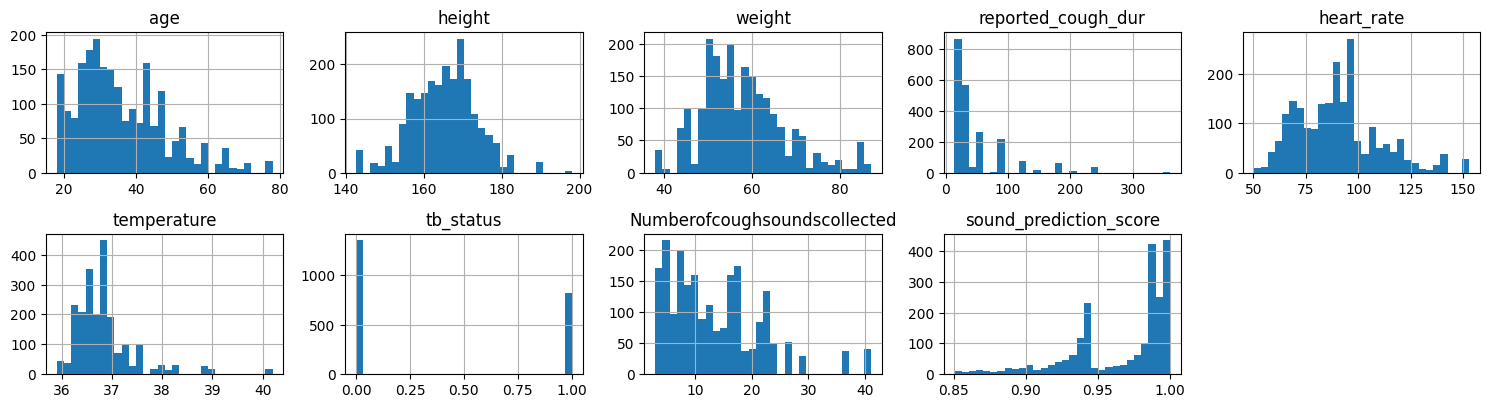

In [56]:
# Visualiser les distributions des caractéristiques numériques.
num_data.hist(bins=30, figsize=(15, 10), layout=(5, 5))
plt.tight_layout()
plt.show()

In [57]:
catdata =cat_data.drop(['participant','audio_signal'],axis =1)

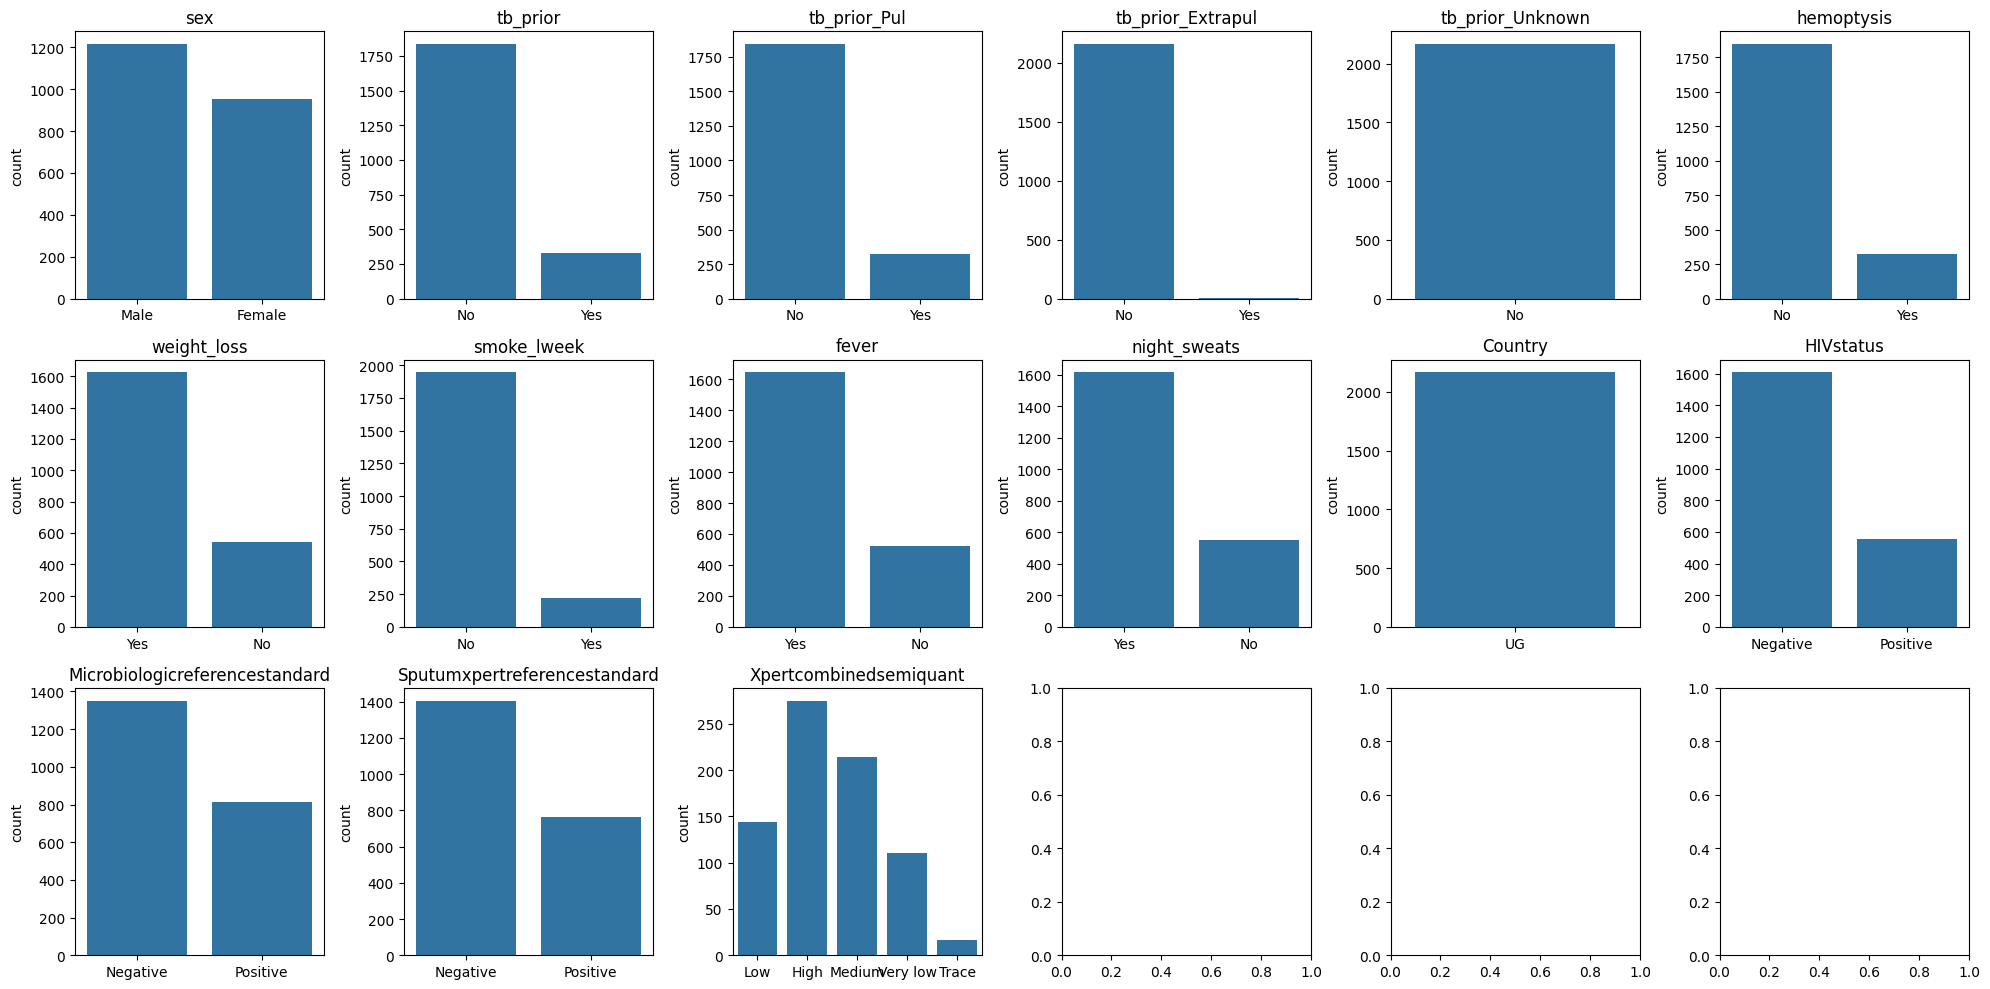

In [58]:
fig,axes = plt.subplots(3,6, figsize= (20,10))
axes = axes.flatten()
for i,col in enumerate(catdata.columns):
    sns.countplot(data = catdata,x = col,ax =axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('count')
plt.tight_layout()
plt.show()
# 3 variables ont été supprimées (participants , type , sample_rate), c'est pour cela qu'on a 3 graphe vide en dessous

In [59]:
#categorielles_cols = combined_data.select_dtypes(include=['object']).columns
#print(f"Colonnes catégorielles : {categorielles_cols}")

In [60]:
#num_data = combined_data.select_dtypes(exclude = 'object')


In [61]:
num_data.columns

Index(['age', 'height', 'weight', 'reported_cough_dur', 'heart_rate',
       'temperature', 'tb_status', 'Numberofcoughsoundscollected',
       'sound_prediction_score'],
      dtype='object')

In [62]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 0 to 9735
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           2166 non-null   int64  
 1   height                        2166 non-null   float64
 2   weight                        2166 non-null   float64
 3   reported_cough_dur            2166 non-null   int64  
 4   heart_rate                    2166 non-null   int64  
 5   temperature                   2166 non-null   float64
 6   tb_status                     2166 non-null   int64  
 7   Numberofcoughsoundscollected  2166 non-null   int64  
 8   sound_prediction_score        2166 non-null   float64
dtypes: float64(4), int64(5)
memory usage: 169.2 KB


In [63]:
num_data.head()

,age,height,weight,reported_cough_dur,heart_rate,temperature,tb_status,Numberofcoughsoundscollected,sound_prediction_score
0,27,173.3,63.0,30,99,37.2,0,18,0.990254
1,27,173.3,63.0,30,99,37.2,0,18,0.990272
2,27,173.3,63.0,30,99,37.2,0,18,0.990112
3,27,173.3,63.0,30,99,37.2,0,18,0.990152
4,27,173.3,63.0,30,99,37.2,0,18,0.990039


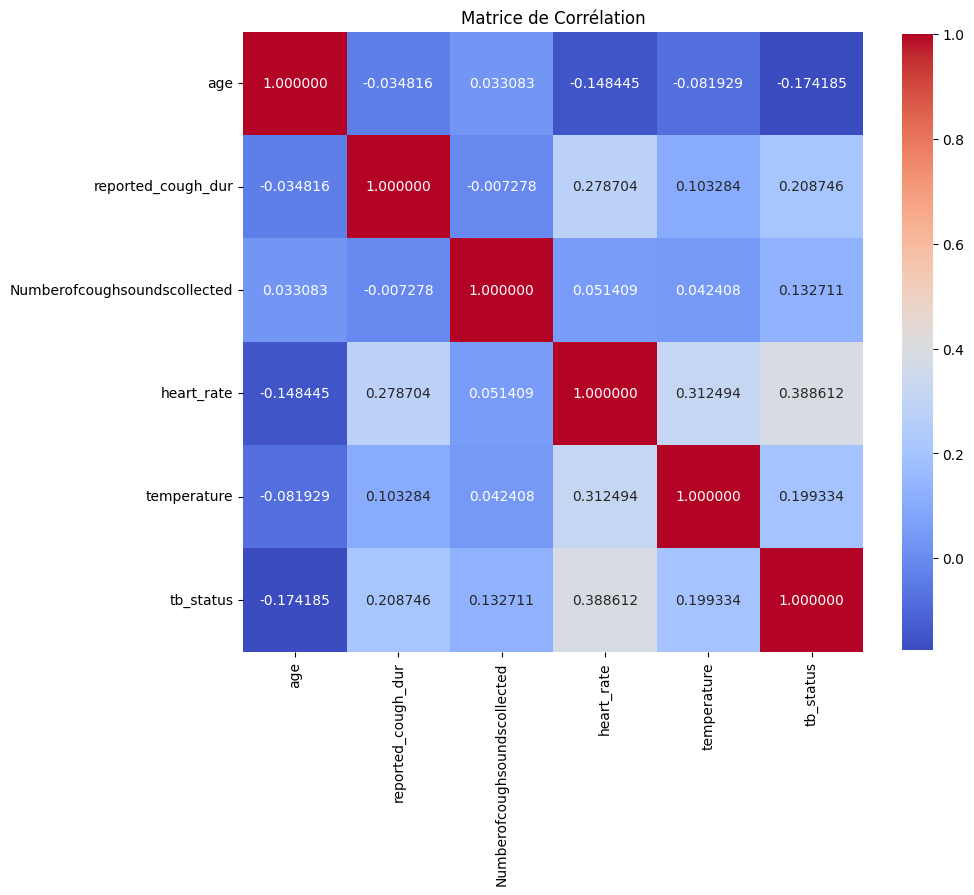

In [64]:
# ['age', 'height', 'weight', 'reported_cough_dur', 'heart_rate','temperature', 'tb_status', 'Numberofcoughsoundscollected',
#       'sound_prediction_score']

# 1. Liste des variables numériques à inclure
variables_a_inclure = [ 'age', 'reported_cough_dur', 'Numberofcoughsoundscollected','heart_rate','temperature', 'tb_status']  # Remplace par les noms de tes colonnes

# 2. Sélectionner uniquement les colonnes spécifiées
num_datamatrice = combined_data[variables_a_inclure]

# 3. Calculer la matrice de corrélation
correlation_matrix = num_datamatrice.corr()

# 4. Visualiser la matrice de corrélation

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.6f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation')
plt.show()



In [65]:
#A REPARERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! UG

In [66]:
# Calculer la matrice de corrélation
correlation_matrix = num_datamatrice.corr()

# Configurer pandas pour afficher toutes les colonnes et ajuster la largeur
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Afficher la matrice de corrélation
print(correlation_matrix)

                                   age  reported_cough_dur  Numberofcoughsoundscollected  heart_rate  temperature  tb_status
age                           1.000000           -0.034816                      0.033083   -0.148445    -0.081929  -0.174185
reported_cough_dur           -0.034816            1.000000                     -0.007278    0.278704     0.103284   0.208746
Numberofcoughsoundscollected  0.033083           -0.007278                      1.000000    0.051409     0.042408   0.132711
heart_rate                   -0.148445            0.278704                      0.051409    1.000000     0.312494   0.388612
temperature                  -0.081929            0.103284                      0.042408    0.312494     1.000000   0.199334
tb_status                    -0.174185            0.208746                      0.132711    0.388612     0.199334   1.000000


## 3- PRE-TRAITEMENTS DES DONNEES

### Ajouter une colonne pour la liste des toux par participants

In [67]:
# 'classement_toux' à déplacer en 2eme position
combined_data['classement_toux'] = combined_data.groupby('participant').cumcount() + 1
col_to_move2 = 'classement_toux'
columns_2 = [col for col in combined_data.columns if col != col_to_move2]
columns_2.insert(2, col_to_move2)
combined_data = combined_data[columns_2]

# 'total_des_toux' à déplacer en 3eme position
combined_data['total_des_toux'] = combined_data.groupby('participant')['reported_cough_dur'].transform('count')
col_to_move = 'total_des_toux'
columns = [col for col in combined_data.columns if col != col_to_move]
columns.insert(3, col_to_move)
combined_data = combined_data[columns]

#---------------------------------------------------------------------------------------------------

#combined_data['classement_total_participant'] = combined_data['classement_toux'].astype(str) + 'sur' + combined_data['total_des_toux'].astype(str)
combined_data.loc[:, 'classement_total_participant'] = combined_data['classement_toux'].astype(str) + '_' + combined_data['total_des_toux'].astype(str)


# 'classement_total_participant' à déplacer en 1ere position
####df['classement_total_participant'] = df.groupby('participant')['reported_cough_dur'].transform('count')
col_to_move1 = 'classement_total_participant'
columns_1 = [col for col in combined_data.columns if col != col_to_move1]
columns_1.insert(1, col_to_move1)
combined_data = combined_data[columns_1]

#---------------------------------------------------------------------------------------------------

# Concaténer les colonnes avec un '/' comme séparateur
#combined_data['participant_palmares_toux'] = combined_data['participant'].astype(str) + '_' + combined_data['classement_total_participant'].astype(str)
combined_data.loc[:, 'participant_record_toux'] = combined_data['participant'].astype(str) + '_' + combined_data['classement_total_participant'].astype(str)


# 'classement_total_participant' à déplacer en 1ere position
####df['classement_total_participant'] = df.groupby('participant')['reported_cough_dur'].transform('count')
col_to_move4 = 'participant_record_toux'
columns_4 = [col for col in combined_data.columns if col != col_to_move4]
columns_4.insert(1, col_to_move4)
combined_data = combined_data[columns_4]

combined_data.head()

,participant,participant_record_toux,classement_total_participant,sex,classement_toux,total_des_toux,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,sound_prediction_score,audio_signal
0,CODA_TB_0001,CODA_TB_0001_1_18,1_18,Male,1,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990254,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ..."
1,CODA_TB_0001,CODA_TB_0001_2_18,2_18,Male,2,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990272,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ..."
2,CODA_TB_0001,CODA_TB_0001_3_18,3_18,Male,3,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990112,"[-54, -41, -20, -10, -19, -8, 8, 27, 37, 53, 3..."
3,CODA_TB_0001,CODA_TB_0001_4_18,4_18,Male,4,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990152,"[-6, -36, -63, -71, -49, -14, -10, -9, -35, -2..."
4,CODA_TB_0001,CODA_TB_0001_5_18,5_18,Male,5,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990039,"[72, 37, 22, 53, 92, 98, 61, 42, 64, 58, 40, 4..."


## 4- PRE-TRAITEMENT DU SIGNAL AUDIO

In [68]:
# Installer en mettre n commentaires
#pip install librosa

## Traitement du vecteur en onde de forme audio 

In [69]:
len(combined_data)

2166

In [70]:
# Appliquer le traitement à tous les échantillons
for i in range(len(combined_data)):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer la STFT
    stft_result = librosa.stft(audio_signal)

    # Convertir en magnitude si nécessaire
    stft_magnitude = np.abs(stft_result)


### Afficher les 10 premières ondes audio brutes

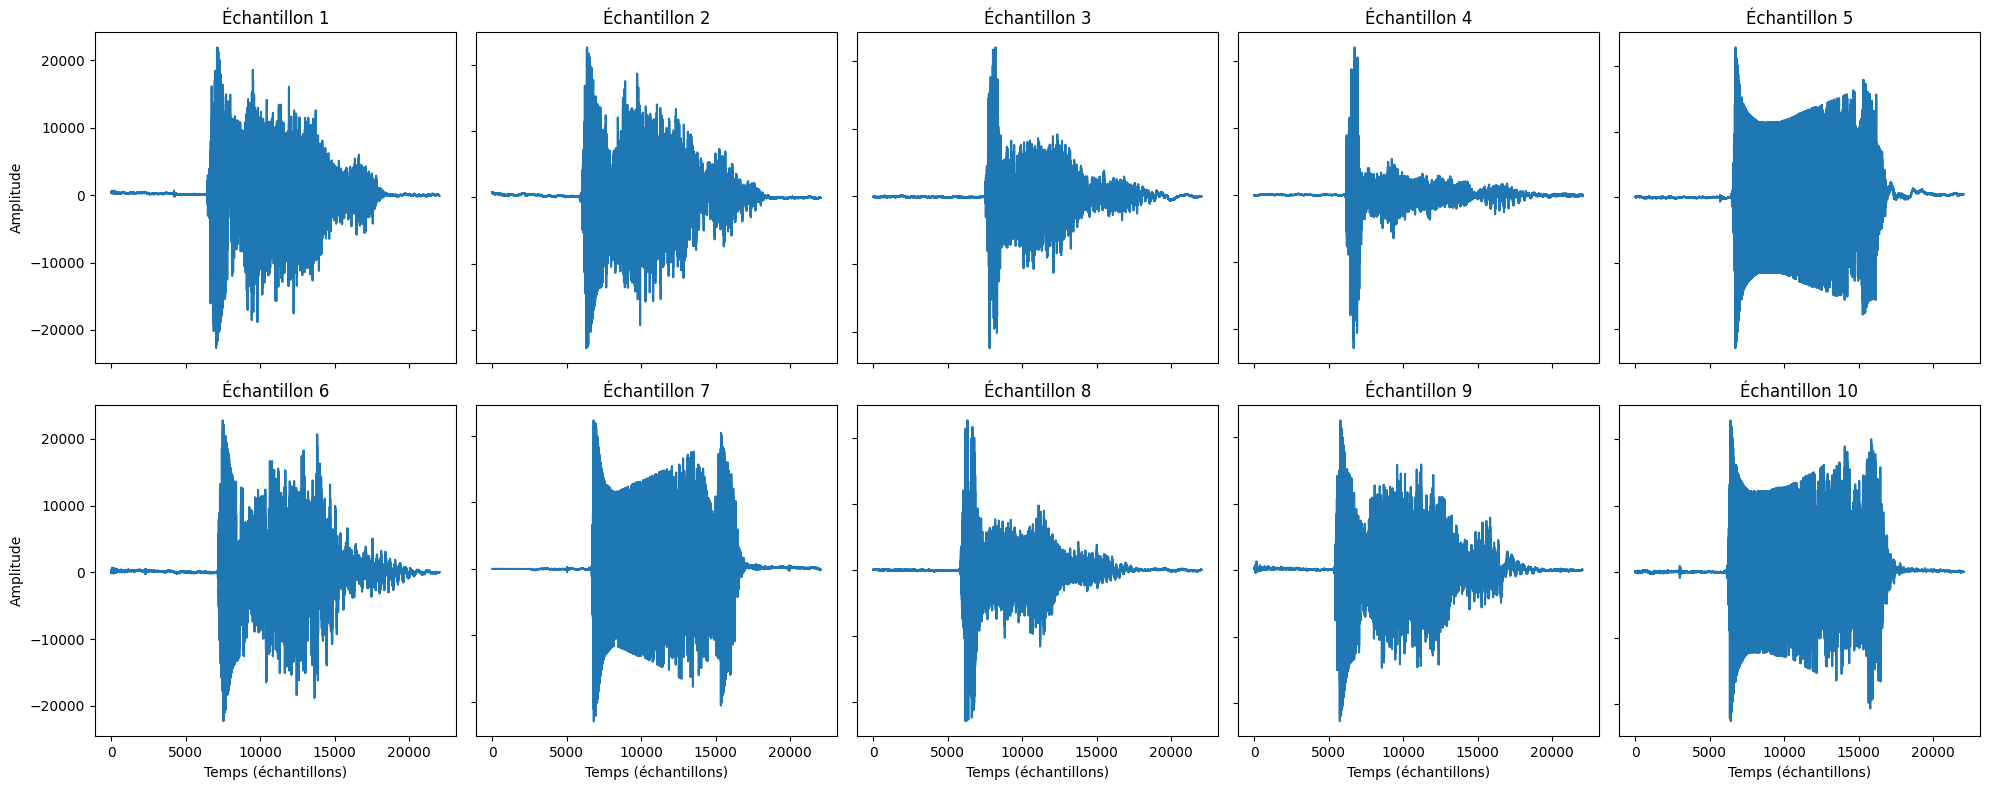

In [71]:
# Créer une figure avec des sous-graphes pour les 10 premiers échantillons
num_samples = min(10, len(combined_data))  # Assurez-vous de ne pas dépasser le nombre d'échantillons
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 lignes et 5 colonnes

# Appliquer le traitement et afficher les 10 premiers échantillons
for i in range(num_samples):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer la STFT
    stft_result = librosa.stft(audio_signal)

    # Convertir en magnitude
    stft_magnitude = np.abs(stft_result)

    # Sélectionner le bon axe pour le sous-graphe
    ax = axes[i // 5, i % 5]  # Calculer la position du sous-graphe

    # Afficher la forme d'onde
    ax.plot(audio_signal)
    ax.set_title(f'Échantillon {i + 1}')
    ax.set_xlabel('Temps (échantillons)')
    ax.set_ylabel('Amplitude')
    ax.label_outer()  # Masquer les labels intérieurs

plt.tight_layout()
plt.show()

## Appliquer la Transformée de Fourier:Short Time Fourier Transform

In [72]:
# Appliquer le traitement à tous les échantillons
for i in range(len(combined_data)):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer la STFT
    stft_result = librosa.stft(audio_signal)

    # Convertir en amplitude
    stft_magnitude = np.abs(stft_result)

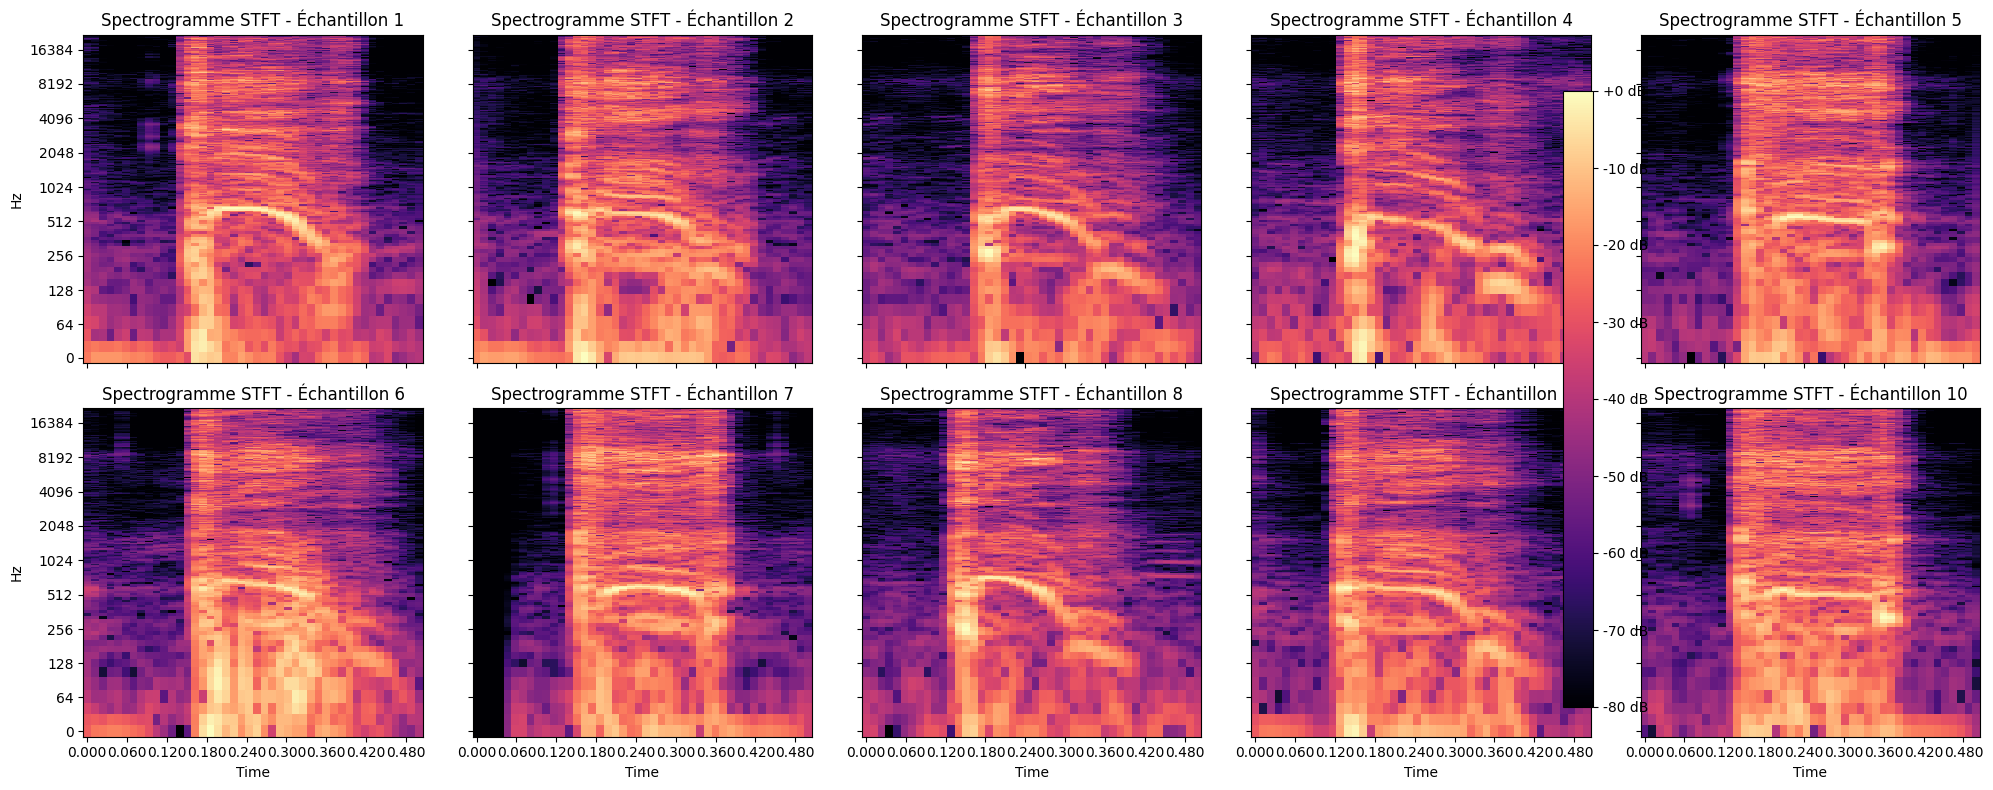

In [73]:
# Créer une figure avec des sous-graphes pour les 10 premiers échantillons
num_samples = min(10, len(combined_data))  
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 lignes et 5 colonnes

# Appliquer le traitement et afficher les 10 premiers échantillons
for i in range(num_samples):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer la STFT
    stft_result = librosa.stft(audio_signal)

    # Convertir en amplitude
    stft_magnitude = np.abs(stft_result)

    # Sélectionner le bon axe pour le sous-graphe
    ax = axes[i // 5, i % 5]  # Calculer la position du sous-graphe

    # Afficher le spectrogramme
    img = librosa.display.specshow(librosa.amplitude_to_db(stft_magnitude, ref=np.max),
                                    sr=44100, x_axis='time', y_axis='log', ax=ax)
    ax.set_title(f'Spectrogramme STFT - Échantillon {i + 1}')
    ax.label_outer()  # Masquer les labels intérieurs

# Ajouter une barre de couleur
fig.colorbar(img, ax=axes, format='%+2.0f dB', orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

## Appliquer Mel Spectrogram

In [74]:
# Appliquer le Mel spectrogram à tous les échantillons
for i in range(len(combined_data)):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    # n_mels : Ce paramètre spécifie le nombre de bandes de fréquence dans l'échelle Mel
    # fmax :  Ce paramètre définit la fréquence maximale que l'on souhaite représenter dans le Mel spectrogram et seules les fréquences allant jusqu'à 8000 Hz seront prises en compte pour le Mel spectrogram. 
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


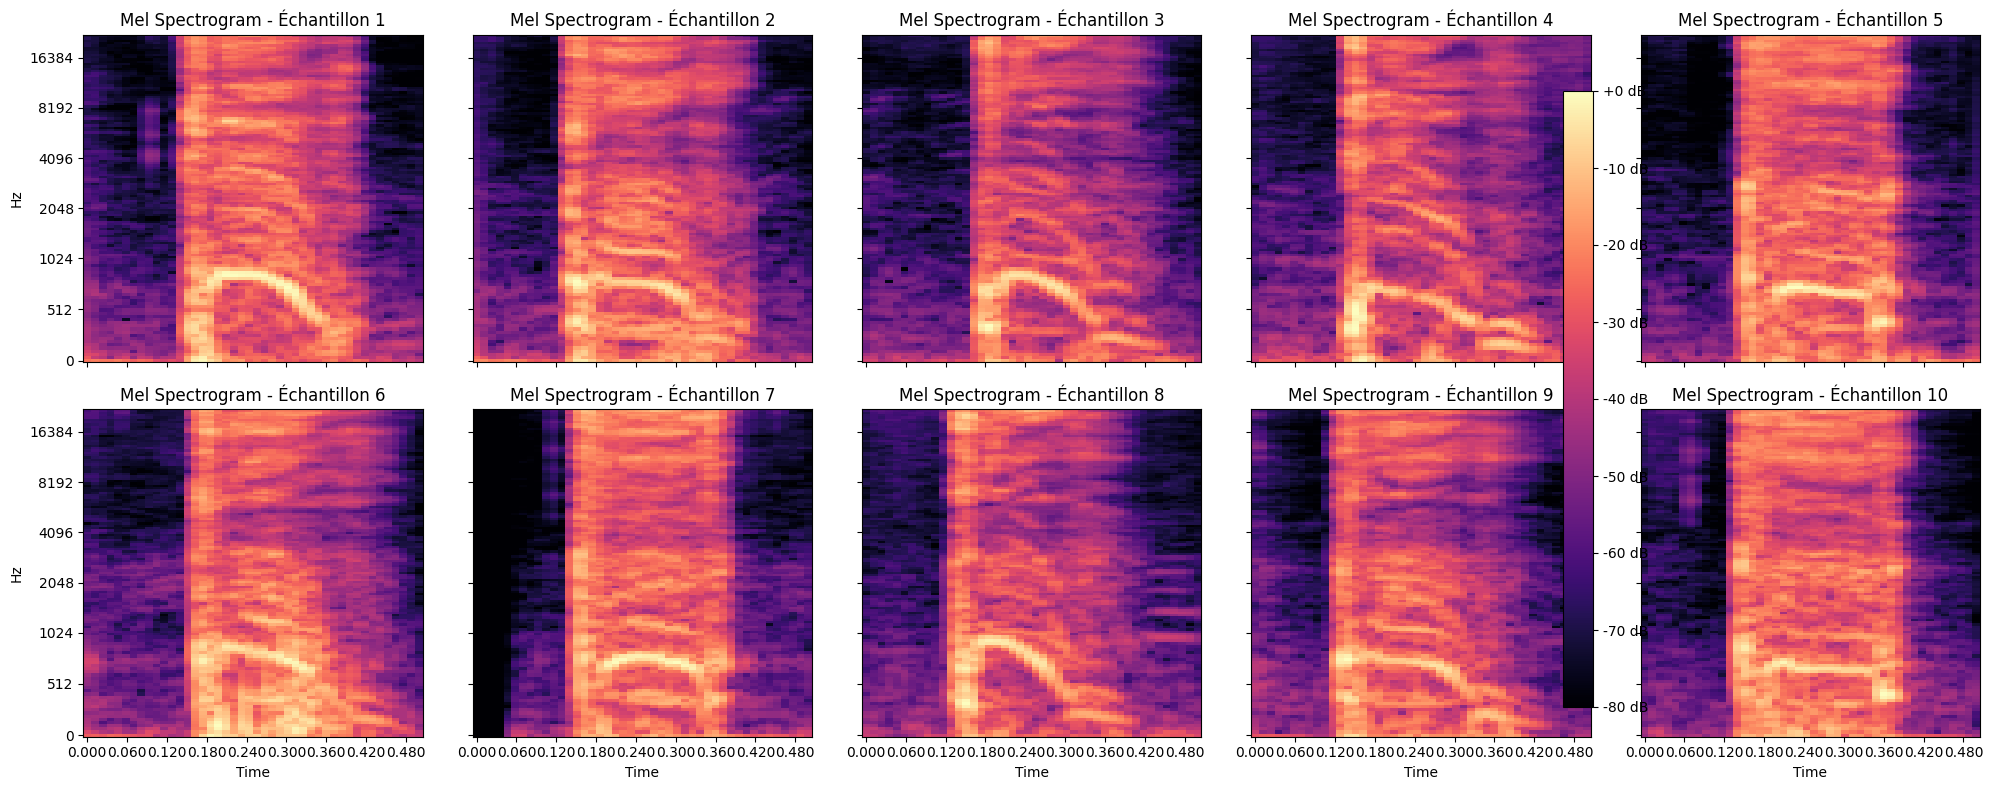

In [75]:
# Créer une figure avec des sous-graphes pour les 10 premiers échantillons
num_samples = min(10, len(combined_data))  # Assurez-vous de ne pas dépasser le nombre d'échantillons
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 lignes et 5 colonnes

# Appliquer le Mel spectrogram et afficher les 10 premiers échantillons
for i in range(num_samples):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Sélectionner le bon axe pour le sous-graphe
    ax = axes[i // 5, i % 5]  # Calculer la position du sous-graphe

    # Afficher le Mel spectrogram
    img = librosa.display.specshow(mel_spectrogram_db, sr=44100, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f'Mel Spectrogram - Échantillon {i + 1}')
    ax.label_outer()  # Masquer les labels intérieurs

# Ajouter une barre de couleur
fig.colorbar(img, ax=axes, format='%+2.0f dB', orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

## Afficher Log Mel Spectogram

In [76]:
# Appliquer le Log Mel spectrogram à tous les échantillons
log_mel_spectrograms = []  # Liste pour stocker les Log Mel spectrograms

for i in range(len(combined_data)):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB (Log Mel spectrogram)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ajouter à la liste
    log_mel_spectrograms.append(log_mel_spectrogram)

# log_mel_spectrograms contient maintenant tous les Log Mel spectrograms

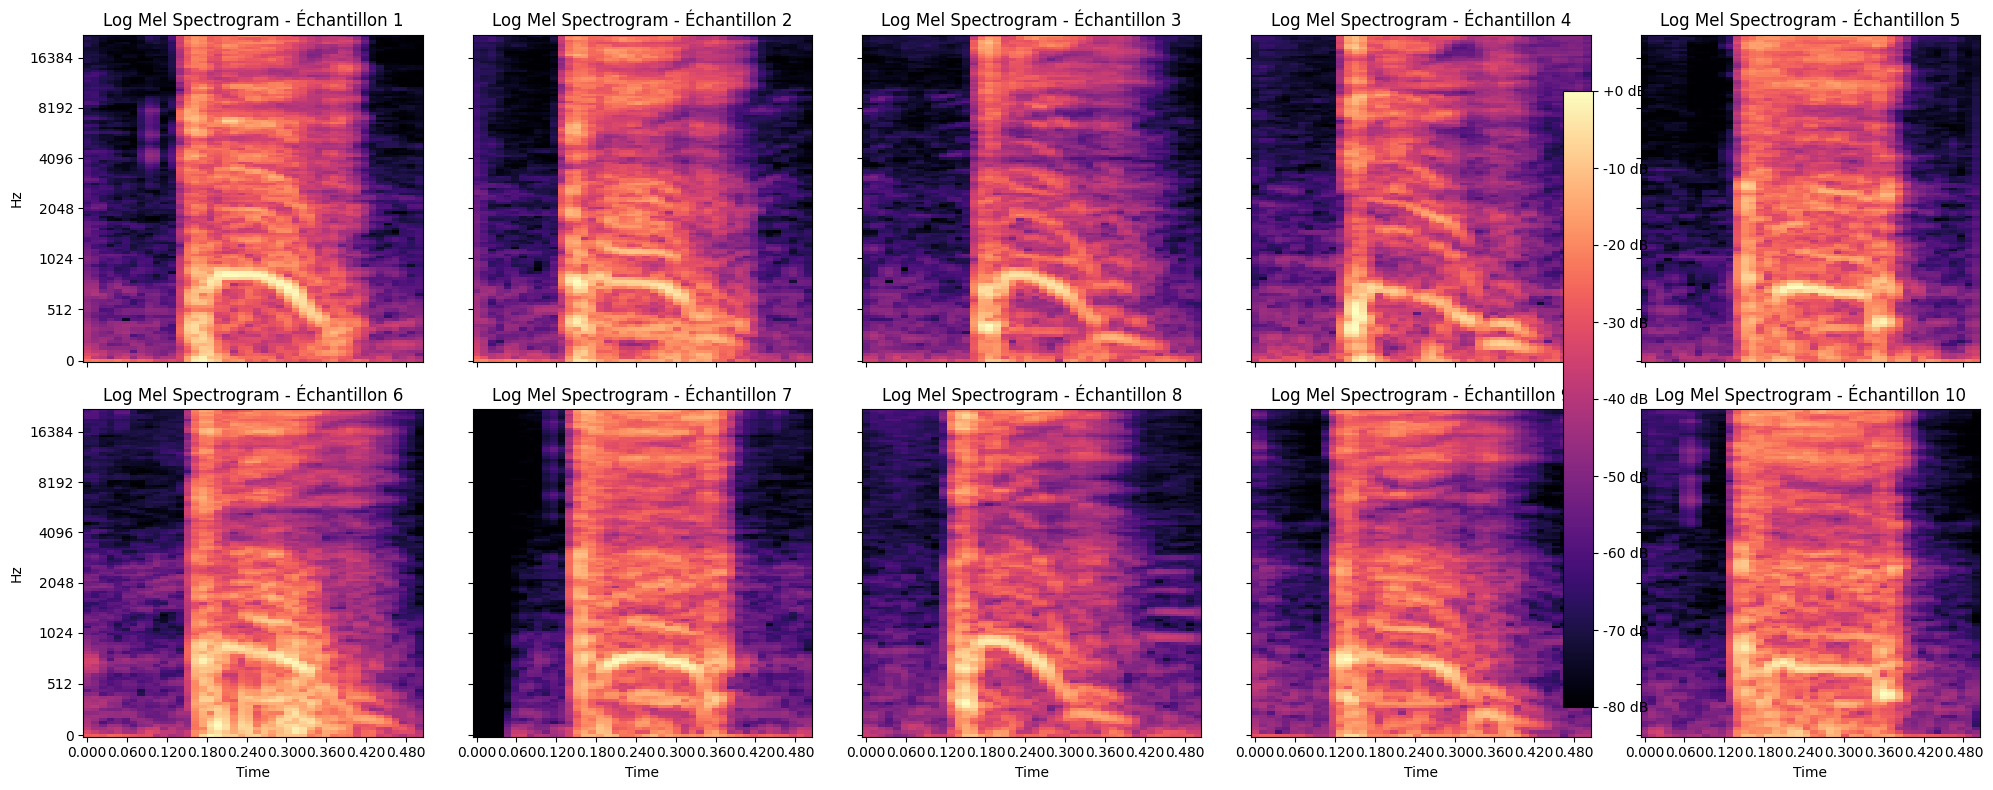

In [77]:
# Créer une figure avec des sous-graphes pour les 10 premiers échantillons
num_samples = min(10, len(combined_data))  # Assurez-vous de ne pas dépasser le nombre d'échantillons
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 lignes et 5 colonnes

# Appliquer le Log Mel spectrogram et afficher les 10 premiers échantillons
for i in range(num_samples):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB (Log Mel spectrogram)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Sélectionner le bon axe pour le sous-graphe
    ax = axes[i // 5, i % 5]  # Calculer la position du sous-graphe

    # Afficher le Log Mel spectrogram
    img = librosa.display.specshow(log_mel_spectrogram, sr=44100, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f'Log Mel Spectrogram - Échantillon {i + 1}')
    ax.label_outer()  # Masquer les labels intérieurs

# Ajouter une barre de couleur
fig.colorbar(img, ax=axes, format='%+2.0f dB', orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

## Appliquer Cosine Discrete Transform

In [78]:
# Liste pour stocker les coefficients DCT
dct_coefficients = []

# Appliquer le Log Mel spectrogram et la DCT à tous les échantillons
for i in range(len(combined_data)):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB (Log Mel spectrogram)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Appliquer la DCT sur chaque colonne du Log Mel spectrogram
    # Ici, nous utilisons la DCT de type II (qui est la plus courante)
    dct_result = dct(log_mel_spectrogram, type=2, axis=0, norm='ortho')

    # Ajouter les coefficients DCT à la liste
    dct_coefficients.append(dct_result)


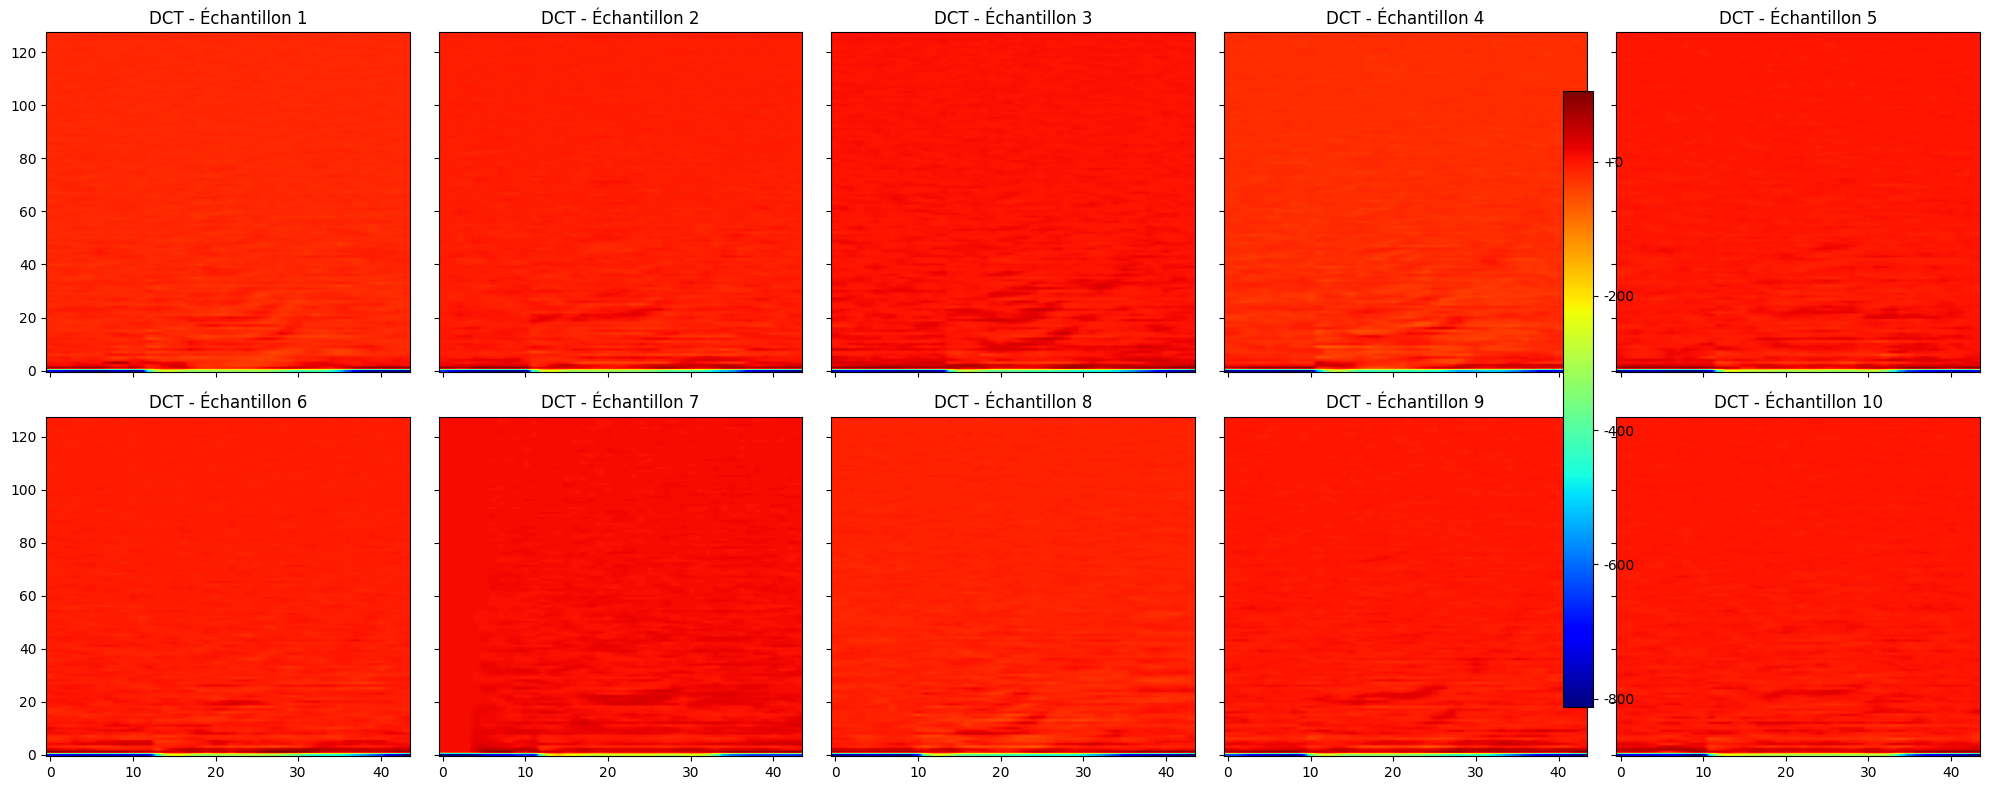

In [79]:
# Créer une figure avec des sous-graphes pour les 10 premiers échantillons
num_samples = min(10, len(combined_data))  # Assurez-vous de ne pas dépasser le nombre d'échantillons
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 lignes et 5 colonnes

# Appliquer le Log Mel spectrogram et la DCT, puis afficher les 10 premiers échantillons
for i in range(num_samples):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB (Log Mel spectrogram)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Appliquer la DCT sur le Log Mel spectrogram
    dct_result = dct(log_mel_spectrogram, type=2, axis=0, norm='ortho')

    # Sélectionner le bon axe pour le sous-graphe
    ax = axes[i // 5, i % 5]  # Calculer la position du sous-graphe

    # Afficher les coefficients DCT
    ax.imshow(dct_result, aspect='auto', origin='lower', cmap='jet')
    ax.set_title(f'DCT - Échantillon {i + 1}')
    ax.label_outer()  # Masquer les labels intérieurs

# Ajouter une barre de couleur
plt.colorbar(ax.imshow(dct_result, aspect='auto', origin='lower', cmap='jet'), ax=axes, format='%+2.0f', orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

## Normaliser la DCT et utiliser cmap='viridis'

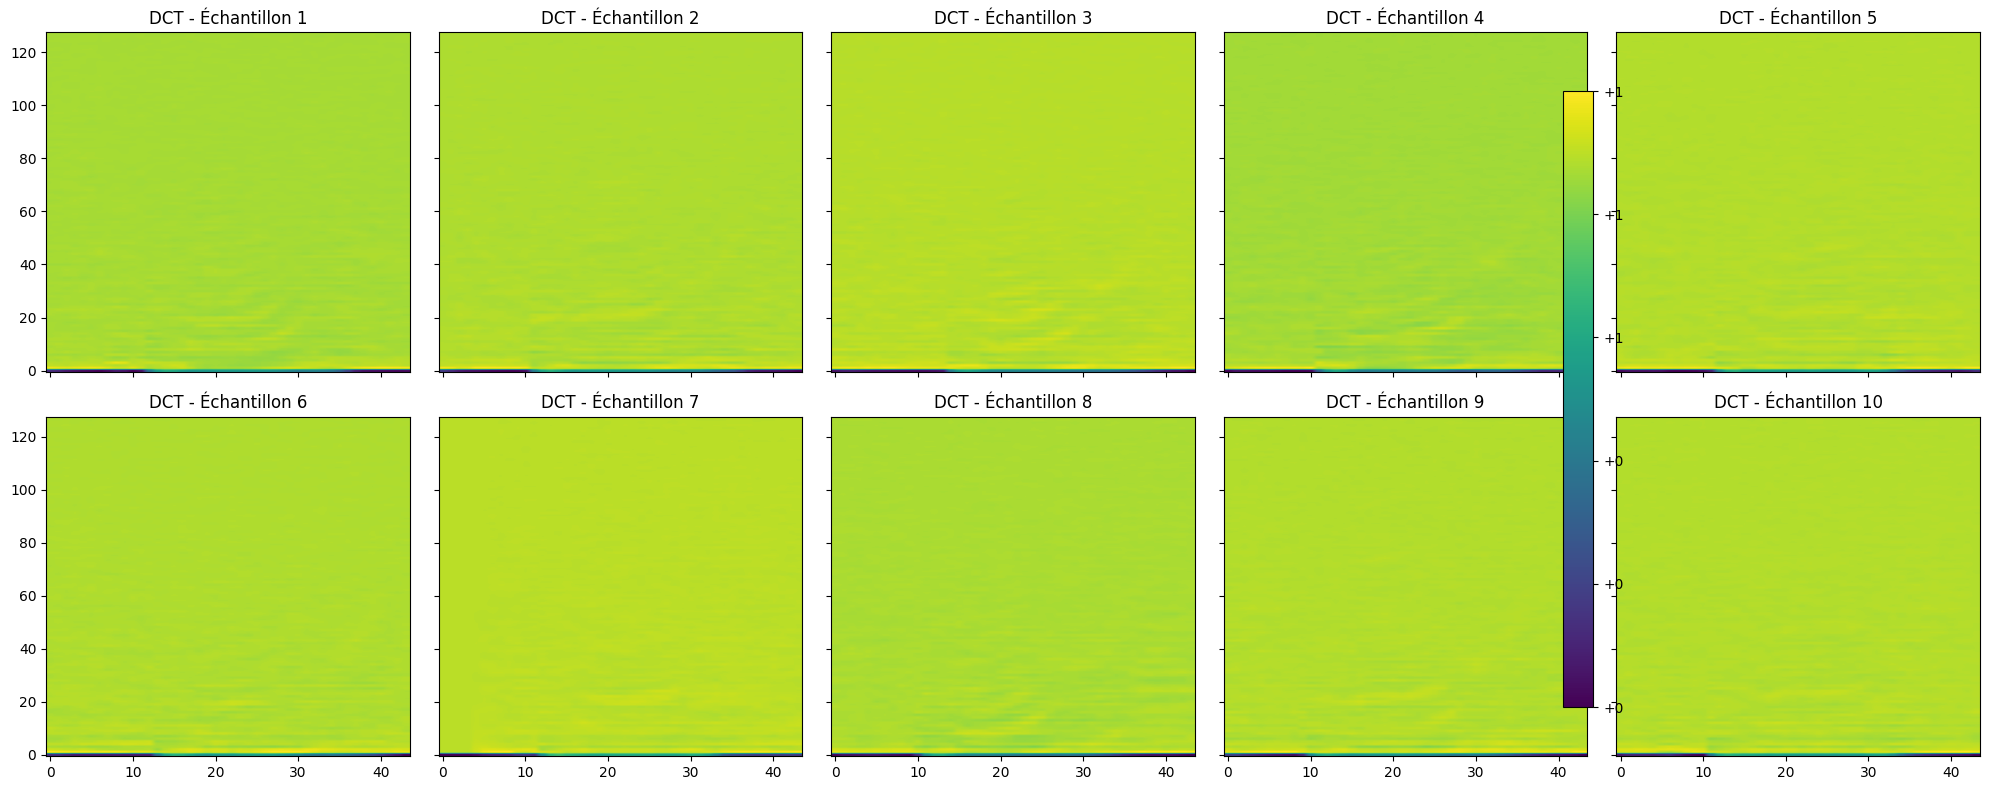

In [80]:
# Créer une figure avec des sous-graphes pour les 10 premiers échantillons
num_samples = min(10, len(combined_data))  # Assurez-vous de ne pas dépasser le nombre d'échantillons
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))  # 2 lignes et 5 colonnes

# Appliquer le Log Mel spectrogram et la DCT, puis afficher les 10 premiers échantillons
for i in range(num_samples):
    audio_signal = combined_data['audio_signal'].iloc[i]  # Récupérer l'échantillon audio

    # Convertir le signal audio en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)

    # Appliquer le Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=44100, n_mels=128, fmax=8000)

    # Convertir en dB (Log Mel spectrogram)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Appliquer la DCT sur le Log Mel spectrogram
    dct_result = dct(log_mel_spectrogram, type=2, axis=0, norm='ortho')

    # Normaliser les valeurs DCT
    dct_result_normalized = (dct_result - np.min(dct_result)) / (np.max(dct_result) - np.min(dct_result))

    # Sélectionner le bon axe pour le sous-graphe
    ax = axes[i // 5, i % 5]  # Calculer la position du sous-graphe

    # Afficher les coefficients DCT normalisés
    ax.imshow(dct_result_normalized, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'DCT - Échantillon {i + 1}')
    ax.label_outer()  # Masquer les labels intérieurs

# Ajouter une barre de couleur
plt.colorbar(ax.imshow(dct_result_normalized, aspect='auto', origin='lower', cmap='viridis'),
             ax=axes, format='%+2.0f', orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()

### Extraire les coefficients cepstraux en fréquence Mel (MFCC) à partir du signal audio ( n_mfcc=13 )

La fonction retourne un tableau contenant les coefficients MFCC, qui sont des représentations compactes des caractéristiques du signal audio.

In [81]:
def preprocess_signal(signal):
    signal = np.array(signal, dtype=np.float32) # Convertit le signal en un tableau NumPy de type float32
    if np.max(np.abs(signal)) > 0:# Vérifie si le signal n'est pas complètement nul
        signal = signal / np.max(np.abs(signal)) # Normalise le signal entre -1 et 1
    return signal

def extract_mfcc(signal, sr=44100, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc) # Calcule les MFCC
    return mfccs

# Extraire les MFCC et stocker les formes
combined_data['mfcc'] = combined_data['audio_signal'].apply(lambda x: extract_mfcc(preprocess_signal(x)))
combined_data['mfcc_shape'] = combined_data['mfcc'].apply(lambda x: x.shape)

# Vérifier le résultat
print(combined_data[['mfcc_shape']].head())

  mfcc_shape
0   (13, 44)
1   (13, 44)
2   (13, 44)
3   (13, 44)
4   (13, 44)


In [82]:
combined_data.head(5)

,participant,participant_record_toux,classement_total_participant,sex,classement_toux,total_des_toux,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,sound_prediction_score,audio_signal,mfcc,mfcc_shape
0,CODA_TB_0001,CODA_TB_0001_1_18,1_18,Male,1,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990254,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ...","[[-392.96967, -411.3173, -456.14334, -477.0735...","(13, 44)"
1,CODA_TB_0001,CODA_TB_0001_2_18,2_18,Male,2,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990272,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ...","[[-369.39105, -409.0158, -447.3704, -464.0849,...","(13, 44)"
2,CODA_TB_0001,CODA_TB_0001_3_18,3_18,Male,3,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990112,"[-54, -41, -20, -10, -19, -8, 8, 27, 37, 53, 3...","[[-489.70325, -463.85233, -462.51584, -470.660...","(13, 44)"
3,CODA_TB_0001,CODA_TB_0001_4_18,4_18,Male,4,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990152,"[-6, -36, -63, -71, -49, -14, -10, -9, -35, -2...","[[-534.2988, -505.94308, -512.0741, -523.0523,...","(13, 44)"
4,CODA_TB_0001,CODA_TB_0001_5_18,5_18,Male,5,18,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990039,"[72, 37, 22, 53, 92, 98, 61, 42, 64, 58, 40, 4...","[[-493.53488, -467.98523, -470.12973, -471.782...","(13, 44)"


## Calculer le nombre total de coefficients MFCC pour chaque signal audio

In [83]:

# Extraire les MFCC
combined_data['mfcc'] = combined_data['audio_signal'].apply(lambda x: extract_mfcc(preprocess_signal(x)))

# Calculer le nombre total de valeurs dans chaque matrice de MFCC
combined_data['mfcc_count'] = combined_data['mfcc'].apply(lambda x: x.size)

# Calcule le nombre total de coefficients MFCC pour chaque signal audio et le stocke dans une colonne mfcc_count.
print(combined_data[['mfcc_count']].head())

   mfcc_count
0         572
1         572
2         572
3         572
4         572


In [84]:
# Obtenir les valeurs uniques dans la colonne mfcc_count
unique_mfcc_counts = combined_data['mfcc_count'].unique()

# Afficher les valeurs uniques
print(unique_mfcc_counts)

[572 481 429 559 520]


Le nombre de coefficiants MFCC varie entre 390 et 572

In [85]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 0 to 9735
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   participant                     2166 non-null   object 
 1   participant_record_toux         2166 non-null   object 
 2   classement_total_participant    2166 non-null   object 
 3   sex                             2166 non-null   object 
 4   classement_toux                 2166 non-null   int64  
 5   total_des_toux                  2166 non-null   int64  
 6   age                             2166 non-null   int64  
 7   height                          2166 non-null   float64
 8   weight                          2166 non-null   float64
 9   reported_cough_dur              2166 non-null   int64  
 10  tb_prior                        2166 non-null   object 
 11  tb_prior_Pul                    2166 non-null   object 
 12  tb_prior_Extrapul               2166 no

In [86]:
# ------ rajouter un dataset trié par participant avec sa toux la plus forte ----------------
#         verifier que le client a une seule classe

### Créer un nouveau dataset pour les features mfcc  ( mfcc_dataset )

In [87]:
# Sélectionner les colonnes souhaitées
selected_columns = [
    'participant_record_toux',
    'Country',
    'audio_signal',
    'mfcc',
    'mfcc_shape',
    'tb_status'
]

# Créer un nouveau DataFrame avec les colonnes sélectionnées
mfcc_dataset = combined_data[selected_columns]

# Vérifier le nouveau DataFrame
mfcc_dataset.head()

,participant_record_toux,Country,audio_signal,mfcc,mfcc_shape,tb_status
0,CODA_TB_0001_1_18,UG,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ...","[[-392.96967, -411.3173, -456.14334, -477.0735...","(13, 44)",0
1,CODA_TB_0001_2_18,UG,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ...","[[-369.39105, -409.0158, -447.3704, -464.0849,...","(13, 44)",0
2,CODA_TB_0001_3_18,UG,"[-54, -41, -20, -10, -19, -8, 8, 27, 37, 53, 3...","[[-489.70325, -463.85233, -462.51584, -470.660...","(13, 44)",0
3,CODA_TB_0001_4_18,UG,"[-6, -36, -63, -71, -49, -14, -10, -9, -35, -2...","[[-534.2988, -505.94308, -512.0741, -523.0523,...","(13, 44)",0
4,CODA_TB_0001_5_18,UG,"[72, 37, 22, 53, 92, 98, 61, 42, 64, 58, 40, 4...","[[-493.53488, -467.98523, -470.12973, -471.782...","(13, 44)",0


In [88]:
mfcc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2166 entries, 0 to 9735
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   participant_record_toux  2166 non-null   object
 1   Country                  2166 non-null   object
 2   audio_signal             2166 non-null   object
 3   mfcc                     2166 non-null   object
 4   mfcc_shape               2166 non-null   object
 5   tb_status                2166 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 118.5+ KB


### Créer 2 classes et créer un dataframe par pays

In [89]:

# Sélectionner les colonnes souhaitées
selected_columns = [
    'participant_record_toux',
    'Country',
    'audio_signal',
    'mfcc',
    'mfcc_shape',
    'tb_status'
]
#----------------------------------------------------------------------------------------------------
# Créer un nouveau DataFrame avec les colonnes sélectionnées
mfcc_dataset = combined_data[selected_columns]

# Fonction pour créer des DataFrames par pays
def get_country_datasets(dataset, country):
    country_dataset = dataset[dataset['Country'] == country].reset_index(drop=True)
    
    class_0_mfcc = country_dataset[country_dataset['tb_status'] == 0].reset_index(drop=True)
    class_1_mfcc = country_dataset[country_dataset['tb_status'] == 1].reset_index(drop=True)
    
    return class_0_mfcc, class_1_mfcc
#----------------------------------------------------------------------------------------------------

# Exemple d'utilisation pour le Vietnam
country_name = 'UG'  # Remplacez par le code du pays souhaité***********************************************************
class_0_mfcc_vn, class_1_mfcc_vn = get_country_datasets(mfcc_dataset, country_name)
#----------------------------------------------------------------------------------------------------

# Initialiser le scaler
scaler = MinMaxScaler()

# Extraire les coefficients MFCC et les normaliser
for i in range(1, 14):  # pour 13 coefficients MFCC
    mfcc_col_0 = []
    for mfcc in class_0_mfcc_vn['mfcc']:
        mfcc_mean = np.mean(mfcc[i-1])  # i-1 car l'index commence à 0
        mfcc_col_0.append(mfcc_mean)
    normalized_mfcc_0 = scaler.fit_transform(np.array(mfcc_col_0).reshape(-1, 1))
    class_0_mfcc_vn[f'mfcc_{i}'] = normalized_mfcc_0

    mfcc_col_1 = []
    for mfcc in class_1_mfcc_vn['mfcc']:
        mfcc_mean = np.mean(mfcc[i-1])  # i-1 car l'index commence à 0
        mfcc_col_1.append(mfcc_mean)
    normalized_mfcc_1 = scaler.fit_transform(np.array(mfcc_col_1).reshape(-1, 1))
    class_1_mfcc_vn[f'mfcc_{i}'] = normalized_mfcc_1
#----------------------------------------------------------------------------------------------------

# Normaliser la colonne mfcc pour la classe 0
normalized_mfccs_0 = []

for mfcc in class_0_mfcc_vn['mfcc']:
    mfcc_flat = mfcc.flatten().reshape(-1, 1)  # Aplatir et remodeler pour le scaler
    normalized_mfcc = scaler.fit_transform(mfcc_flat)  # Normaliser
    normalized_mfccs_0.append(normalized_mfcc.flatten())  # Renvoyer à la forme aplatie

class_0_mfcc_vn['normalized_mfcc'] = normalized_mfccs_0
#----------------------------------------------------------------------------------------------------

# Normaliser la colonne mfcc pour la classe 1
normalized_mfccs_1 = []

for mfcc in class_1_mfcc_vn['mfcc']:
    mfcc_flat = mfcc.flatten().reshape(-1, 1)  # Aplatir et remodeler pour le scaler
    normalized_mfcc = scaler.fit_transform(mfcc_flat)  # Normaliser
    normalized_mfccs_1.append(normalized_mfcc.flatten())  # Renvoyer à la forme aplatie

class_1_mfcc_vn['normalized_mfcc'] = normalized_mfccs_1
#----------------------------------------------------------------------------------------------------

# Créer les dossiers pour les classes s'ils n'existent pas
os.makedirs('classe_0/UG/Participant_Unique', exist_ok=True)# Remplacez par le code du pays souhaité**********************
os.makedirs('classe_1/UG/Participant_Unique', exist_ok=True)# Remplacez par le code du pays souhaité**********************

# Sauvegarder les DataFrames en fichiers pickle par participant pour la classe 0
for idx, group in class_0_mfcc_vn.groupby('participant_record_toux'):
    participant_number = idx.split('_')[2]  # Extrait le numéro du participant
    filename = f'classe_0/UG/Participant_Unique/CODA_TB_{participant_number}.pkl' #*********************************
    group.to_pickle(filename)

# Sauvegarder les DataFrames en fichiers pickle par participant pour la classe 1
for idx, group in class_1_mfcc_vn.groupby('participant_record_toux'):
    participant_number = idx.split('_')[2]  # Extrait le numéro du participant
    filename = f'classe_1/UG/Participant_Unique/CODA_TB_{participant_number}.pkl'# ****************************************
    group.to_pickle(filename)

print("DataFrames sauvegardés avec succès.")

DataFrames sauvegardés avec succès.


In [90]:
# Vérifier les nouveaux DataFrames
print(f"Classe 0 Dataset pour {country_name}:")
class_0_mfcc_vn.head()
#print(class_0_mfcc_vn.shape)

Classe 0 Dataset pour UG:


,participant_record_toux,Country,audio_signal,mfcc,mfcc_shape,tb_status,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,normalized_mfcc
0,CODA_TB_0001_1_18,UG,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ...","[[-392.96967, -411.3173, -456.14334, -477.0735...","(13, 44)",0,0.431405,0.334411,0.527484,0.566496,0.729897,0.472483,0.454178,0.625924,0.620145,0.404209,0.546731,0.477675,0.617142,"[0.18282723, 0.15330571, 0.081180096, 0.047503..."
1,CODA_TB_0001_2_18,UG,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ...","[[-369.39105, -409.0158, -447.3704, -464.0849,...","(13, 44)",0,0.445834,0.360430,0.605072,0.652342,0.526352,0.425024,0.814361,0.683551,0.547174,0.312260,0.595923,0.479132,0.604379,"[0.21410221, 0.15024745, 0.088439524, 0.061504..."
2,CODA_TB_0001_3_18,UG,"[-54, -41, -20, -10, -19, -8, 8, 27, 37, 53, 3...","[[-489.70325, -463.85233, -462.51584, -470.660...","(13, 44)",0,0.317284,0.328468,0.624658,0.710924,0.479605,0.504502,0.665627,0.627295,0.615610,0.378731,0.675859,0.603460,0.719315,"[0.050376534, 0.09196675, 0.094116926, 0.08101..."
3,CODA_TB_0001_4_18,UG,"[-6, -36, -63, -71, -49, -14, -10, -9, -35, -2...","[[-534.2988, -505.94308, -512.0741, -523.0523,...","(13, 44)",0,0.259754,0.278737,0.591600,0.721789,0.615225,0.458939,0.755203,0.684835,0.715571,0.401857,0.565126,0.276992,0.390698,"[0.017836273, 0.06035483, 0.051161587, 0.03470..."
4,CODA_TB_0001_5_18,UG,"[72, 37, 22, 53, 92, 98, 61, 42, 64, 58, 40, 4...","[[-493.53488, -467.98523, -470.12973, -471.782...","(13, 44)",0,0.469097,0.320530,0.602584,0.561011,0.448269,0.506267,0.774413,0.507677,0.602100,0.370561,0.664311,0.504960,0.698182,"[0.023527622, 0.06398797, 0.060591936, 0.05797..."


In [91]:
print(f"\nClasse 1 Dataset pour {country_name}:")
class_1_mfcc_vn.head()


Classe 1 Dataset pour UG:


,participant_record_toux,Country,audio_signal,mfcc,mfcc_shape,tb_status,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,normalized_mfcc
0,CODA_TB_0016_1_5,UG,"[-155, -177, -145, -123, -116, -157, -132, -12...","[[-478.62466, -465.61453, -462.40088, -461.417...","(13, 44)",1,0.261214,0.297685,0.453951,0.144387,0.529518,0.693286,0.412448,0.339467,0.218528,0.554857,0.722612,0.195097,0.521505,"[0.043527722, 0.064597726, 0.069802225, 0.0713..."
1,CODA_TB_0016_2_5,UG,"[-60, -62, -63, -48, -40, -26, -19, -36, -34, ...","[[-478.73132, -458.2449, -459.3261, -459.70538...","(13, 44)",1,0.417195,0.230419,0.504456,0.259738,0.324920,0.395986,0.473331,0.234593,0.388891,0.549406,0.894381,0.476257,0.732701,"[0.0, 0.034556568, 0.032732785, 0.032093048, 0..."
2,CODA_TB_0016_3_5,UG,"[-39, -26, -31, -40, -48, -43, -32, -28, -37, ...","[[-539.9082, -510.819, -511.01782, -517.2852, ...","(13, 44)",1,0.236366,0.310132,0.527084,0.449931,0.319726,0.368770,0.500694,0.511732,0.551464,0.401189,0.814584,0.475049,0.392914,"[0.0, 0.04477334, 0.04446733, 0.034820676, 0.0..."
3,CODA_TB_0016_4_5,UG,"[-118, -141, -138, -131, -137, -129, -126, -10...","[[-469.67798, -457.36722, -458.77036, -459.596...","(13, 44)",1,0.355690,0.389714,0.413712,0.274631,0.521896,0.511003,0.587769,0.000000,0.297928,0.484936,0.962883,0.475722,0.326825,"[0.0, 0.020473301, 0.01813984, 0.016765356, 0...."
4,CODA_TB_0016_5_5,UG,"[71, 50, 78, 101, 98, 60, 41, 60, 68, 51, 21, ...","[[-455.99396, -438.0063, -437.11154, -440.4582...","(13, 44)",1,0.382352,0.326820,0.552409,0.035867,0.499691,0.741495,0.363564,0.379497,0.367517,0.383713,0.691792,0.135487,0.516329,"[0.0, 0.030666947, 0.03219241, 0.026486635, 0...."


- Maintenant le but est d'avoir une seule toux par participant
- 

### Calculer l'énergie maximale pour toutes les toux d'un même participant

* Prendre la toux avec l'énergie la plus élevée par patient peut être une approche pertinente, surtout si vous supposez que cette toux est représentative de la sévérité de la condition. 
Voici quelques points à considérer pour évaluer cette méthode :

* Pertinence de l'Approche
1.Représentativité : La toux la plus forte peut être celle qui a le plus d'impact sur la classification. Cela pourrait indiquer une exacerbation des symptômes.
2.Variabilité : Vérifiez si la toux la plus forte est vraiment représentative de l'état général du patient. Si un patient a plusieurs épisodes de toux, cela peut varier en intensité.

* Évaluation du Code
Le code que vous avez fourni est pertinent pour calculer l'énergie de chaque échantillon audio et identifier la toux la plus forte. Voici quelques points à noter :
* 1.Calcul de l'énergie : La méthode que vous utilisez pour calculer l'énergie est correcte, car elle fait la somme des carrés des valeurs du signal audio, ce qui donne une mesure de l'intensité.
* 2.Identification de la toux la plus forte : La ligne que vous avez utilisée pour trouver la toux avec l'énergie la plus élevée est correcte. Cela utilise idxmax() pour obtenir l'index de l'énergie maximale, puis sélectionne la ligne correspondante dans participant_df.

In [92]:
# Créer des dossiers pour sauvegarder les fichiers des participants uniques
os.makedirs('classe_0/UG/Participant_Unique_Energy', exist_ok=True)# Remplacez par le code du pays souhaité**********************
os.makedirs('classe_1/UG/Participant_Unique_Energy', exist_ok=True)# Remplacez par le code du pays souhaité**********************

# Fonction pour traiter une classe donnée
def process_class(class_folder, output_folder):
    results = []
    scaler = MinMaxScaler()  # Initialiser le scaler

    for filename in os.listdir(class_folder):
        if filename.endswith('.pkl'):
            # Charger le DataFrame
            participant_df = pd.read_pickle(os.path.join(class_folder, filename))
            
            # Calculer l'énergie de chaque échantillon audio
            participant_df['energy'] = participant_df['audio_signal'].apply(lambda x: np.sum(np.square(x)))
            
            # Trouver la toux avec l'énergie la plus forte - CALCUL ICI--------------------
            strongest_cough = participant_df.loc[participant_df['energy'].idxmax()]
            
            # Extraire les coefficients MFCC
            mfcc_values = np.array([strongest_cough['mfcc'][i] for i in range(len(strongest_cough['mfcc']))])
            
            # Calculer la moyenne des coefficients MFCC
            mfcc_means = np.mean(mfcc_values, axis=1)

            # Normaliser les coefficients MFCC
            mfcc_means_normalized = scaler.fit_transform(mfcc_means.reshape(-1, 1)).flatten()
            
            # Ajouter le résultat à la liste
            results.append({
                'participant_record_toux': strongest_cough['participant_record_toux'],
                'Country': strongest_cough['Country'],
                'tb_status': strongest_cough['tb_status'],
                'strongest_energy': strongest_cough['energy'],
                **{f'mfcc_{i+1}': mfcc_means[i] for i in range(len(mfcc_means))},  # Ajouter les MFCC
                **{f'mfcc_{i+1}_normalized': mfcc_means_normalized[i] for i in range(len(mfcc_means_normalized))}  # Ajouter les MFCC normalisés
            })

            # Sauvegarder la toux la plus forte dans un nouveau fichier
            strongest_cough.to_pickle(f'{output_folder}/{strongest_cough["participant_record_toux"]}.pkl')

    # Créer un DataFrame avec les résultats
    strongest_cough_df = pd.DataFrame(results)

    # Sauvegarder le DataFrame dans le dossier approprié
    strongest_cough_df.to_pickle(f'{output_folder}/strongest_coughs.pkl')

    # Afficher les 5 premiers résultats
    print(strongest_cough_df.head())

# Traiter la classe 0     **********************************************************************************************
process_class('classe_0/UG/Participant_Unique', 'classe_0/UG/Participant_Unique_Energy')# **** Remplacez par le code du pays souhaité**********************

# Traiter la classe 1
process_class('classe_1/UG/Participant_Unique', 'classe_1/UG/Participant_Unique_Energy')# *****Remplacez par le code du pays souhaité**********************

  participant_record_toux Country  tb_status  strongest_energy      mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11   mfcc_12   mfcc_13  mfcc_1_normalized  mfcc_2_normalized  mfcc_3_normalized  mfcc_4_normalized  mfcc_5_normalized  mfcc_6_normalized  mfcc_7_normalized  mfcc_8_normalized  mfcc_9_normalized  mfcc_10_normalized  mfcc_11_normalized  mfcc_12_normalized  mfcc_13_normalized
0       CODA_TB_0001_9_18      UG          0          40216419 -220.745895  65.829254  27.011854  32.761227 -23.230591  11.314826  22.190041  -6.510594  -3.283910 -12.727584   7.164924  1.887657  9.859139           0.000000                1.0           0.864547           0.884610           0.689227           0.809773           0.847722           0.747571           0.758831            0.725877            0.795292            0.776877            0.804693
1        CODA_TB_0011_5_5      UG          0          13471828  -61.996227  55.340965 -2

In [93]:
# CLASSE 0
# Lire le fichier pickle
strongest_cough_df_0 = pd.read_pickle('classe_0/UG/Participant_Unique_Energy/strongest_coughs.pkl') #********************
# Afficher les 5 premières lignes du DataFrame
strongest_cough_df_0

,participant_record_toux,Country,tb_status,strongest_energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_1_normalized,mfcc_2_normalized,mfcc_3_normalized,mfcc_4_normalized,mfcc_5_normalized,mfcc_6_normalized,mfcc_7_normalized,mfcc_8_normalized,mfcc_9_normalized,mfcc_10_normalized,mfcc_11_normalized,mfcc_12_normalized,mfcc_13_normalized
0,CODA_TB_0001_9_18,UG,0,40216419,-220.745895,65.829254,27.011854,32.761227,-23.230591,11.314826,22.190041,-6.510594,-3.283910,-12.727584,7.164924,1.887657,9.859139,0.000000,1.000000,0.864547,0.884610,0.689227,0.809773,0.847722,0.747571,0.758831,0.725877,0.795292,0.776877,0.804693
1,CODA_TB_0011_5_5,UG,0,13471828,-61.996227,55.340965,-21.611328,7.559262,-9.489150,13.779888,0.610261,-13.985180,-12.915201,-16.537085,-10.976508,-3.035913,-2.867517,0.000000,1.000000,0.344178,0.592783,0.447489,0.645798,0.533561,0.409172,0.418290,0.387423,0.434813,0.502486,0.503921
2,CODA_TB_0018_9_10,UG,0,50853580,-350.126556,67.668709,33.078777,37.212849,-5.730752,32.477695,12.558567,-17.811426,11.546260,1.560067,10.436554,-0.891345,-1.222140,0.000000,1.000000,0.917208,0.927103,0.824317,0.915770,0.868093,0.795402,0.865670,0.841768,0.863014,0.835900,0.835109
3,CODA_TB_0021_9_11,UG,0,2586672,-2.245431,75.453865,1.373208,-3.373594,1.108434,11.257644,0.697173,0.098171,-10.297005,3.201377,4.089149,-9.107693,3.823714,0.093895,1.000000,0.136094,0.080739,0.133007,0.251364,0.128211,0.121225,0.000000,0.157414,0.167767,0.013869,0.164671
4,CODA_TB_0029_9_17,UG,0,38475803,-173.495453,79.877594,-24.143217,0.552219,-4.273500,-1.216777,7.410943,-8.154237,-16.898289,-10.102185,-1.079619,8.105066,-4.580686,0.000000,1.000000,0.589456,0.686923,0.667877,0.679941,0.713992,0.652560,0.618050,0.644872,0.680482,0.716732,0.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,CODA_TB_1081_4_4,UG,0,10533668,-95.156906,55.568665,15.548151,44.098293,-0.657611,14.345505,17.844893,-7.991839,3.720941,-2.754507,0.949450,3.733217,0.850911,0.000000,1.000000,0.734481,0.923899,0.626963,0.726502,0.749719,0.578303,0.656012,0.613051,0.637625,0.656094,0.636971
151,CODA_TB_1083_9_12,UG,0,18451929,-180.772232,85.688446,45.083733,21.801285,-11.808976,27.599943,0.066948,-8.682576,10.188796,-7.591116,5.935766,-2.406313,3.703988,0.000000,1.000000,0.847615,0.760238,0.634102,0.782000,0.678671,0.645835,0.716657,0.649931,0.700696,0.669389,0.692321
152,CODA_TB_1098_4_4,UG,0,21914869,-96.754829,64.101402,23.467064,22.469074,-11.633372,21.513796,8.972802,-8.107164,6.659804,-12.271874,5.489031,2.204206,-1.281354,0.000000,1.000000,0.747387,0.741183,0.529177,0.735244,0.657280,0.551099,0.642901,0.525208,0.635623,0.615202,0.593533
153,CODA_TB_1099_9_17,UG,0,88082966,-329.556183,43.859219,10.240170,44.082409,1.727712,14.973575,18.857765,-3.229660,6.152001,-2.499464,4.626350,7.853180,-2.719070,0.000000,0.999403,0.909425,1.000000,0.886643,0.922094,0.932489,0.873375,0.898484,0.875329,0.894401,0.903037,0.874741


In [94]:
strongest_cough_df_0['tb_status'].unique()

array([0], dtype=int64)

In [95]:
# CLASSE 1
# Lire le fichier pickle
strongest_cough_df_1 = pd.read_pickle('classe_1/UG/Participant_Unique_Energy/strongest_coughs.pkl')
# Afficher les 5 premières lignes du DataFrame
strongest_cough_df_1

,participant_record_toux,Country,tb_status,strongest_energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_1_normalized,mfcc_2_normalized,mfcc_3_normalized,mfcc_4_normalized,mfcc_5_normalized,mfcc_6_normalized,mfcc_7_normalized,mfcc_8_normalized,mfcc_9_normalized,mfcc_10_normalized,mfcc_11_normalized,mfcc_12_normalized,mfcc_13_normalized
0,CODA_TB_0016_5_5,UG,1,50620187,-209.818298,77.262581,-2.171879,-3.745193,-8.005714,29.102642,3.100494,-16.395905,-3.454126,-14.041047,7.342539,-12.167777,-0.310421,0.0,1.0,0.723303,0.717822,0.702982,0.832243,0.741668,0.673756,0.718836,0.681959,0.756445,0.688484,0.729787
1,CODA_TB_0028_9_16,UG,1,6758175,-109.256104,54.672024,34.941696,37.627865,-15.470630,11.576776,16.702503,-11.624045,9.153325,-10.207867,4.270325,-1.992015,0.312275,0.0,1.0,0.879640,0.896027,0.572113,0.737109,0.768377,0.595578,0.722325,0.604217,0.692538,0.654336,0.668393
2,CODA_TB_0041_3_3,UG,1,8879486,-86.224113,54.514919,18.925291,17.307735,-14.706826,29.903639,18.497330,-13.322797,10.143516,2.161738,6.635728,2.872165,2.150794,0.0,1.0,0.747123,0.735630,0.508155,0.825128,0.744082,0.517989,0.684726,0.628012,0.659802,0.633060,0.627935
3,CODA_TB_0091_9_15,UG,1,24057749,-187.506638,92.380791,17.040579,34.409672,-8.453765,13.187676,19.766129,-6.391695,16.200037,-10.245959,3.970290,-0.015914,3.826186,0.0,1.0,0.730820,0.792877,0.639732,0.717054,0.740558,0.647099,0.727816,0.633328,0.684121,0.669879,0.683606
4,CODA_TB_0101_9_18,UG,1,-769886,-74.283897,80.529755,24.592896,32.641468,-3.851165,17.843035,0.629915,-5.829128,16.819883,-11.689130,10.708243,3.542281,0.489048,0.0,1.0,0.638683,0.690671,0.454952,0.595083,0.483897,0.442175,0.588474,0.404323,0.548996,0.502709,0.482987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,CODA_TB_1032_9_22,UG,1,13048437,-71.781937,91.396912,-24.316805,12.958875,-5.928535,26.488934,-1.304262,-6.314064,-7.221372,-4.162986,4.019858,-3.794227,-0.755389,0.0,1.0,0.290878,0.519312,0.403566,0.602228,0.431904,0.401203,0.395643,0.414385,0.464532,0.416645,0.435268
74,CODA_TB_1052_5_5,UG,1,6002372,-75.991425,108.758179,1.059316,16.868231,12.099725,7.919398,-5.115079,1.413182,3.476377,-7.533903,-4.417161,3.649405,-7.474247,0.0,1.0,0.417055,0.502624,0.476814,0.454187,0.383635,0.418970,0.430138,0.370542,0.387412,0.431074,0.370865
75,CODA_TB_1073_5_5,UG,1,14529179,-119.613525,98.071022,0.669833,9.509688,-8.075621,13.266672,9.420244,1.026639,2.916972,-1.408639,-2.431271,7.002667,6.386781,0.0,1.0,0.552558,0.593167,0.512383,0.610426,0.592756,0.554197,0.562881,0.543010,0.538312,0.581650,0.578821
76,CODA_TB_1084_9_15,UG,1,37803763,-226.705368,45.667362,20.741600,31.650160,6.060838,24.900785,6.539100,-13.371728,14.886567,-18.826042,8.673158,6.198038,-4.086106,0.0,1.0,0.908487,0.948537,0.854587,0.923757,0.856343,0.783242,0.886990,0.763216,0.864178,0.855091,0.817333


In [96]:
strongest_cough_df_1['tb_status'].unique()

array([1], dtype=int64)

### Combiner les 2 fichiers strongest_coughs.pkl de la classe 0 et celui de la classe 1 en un seul fichier .pkl

In [97]:
# Créer le dossier KFold s'il n'existe pas déjà
os.makedirs('KFold/UG', exist_ok=True) #**************************************

# Charger les deux DataFrames à partir des fichiers pickle
class_0_df = pd.read_pickle('classe_0/UG/Participant_Unique_Energy/strongest_coughs.pkl') #******************
class_1_df = pd.read_pickle('classe_1/UG/Participant_Unique_Energy/strongest_coughs.pkl') #******************

# Combiner les DataFrames
combined_classes_0_1_strongest_coughs = pd.concat([class_0_df, class_1_df], ignore_index=True)

# Sauvegarder le DataFrame combiné dans le dossier KFold
combined_classes_0_1_strongest_coughs.to_pickle('KFold/UG/combined_classes_0_1_strongest_coughs.pkl') #******************

In [98]:
# Charger le DataFrame à partir du fichier pickle
combined_classes_0_1_strongest_coughs = pd.read_pickle('KFold/UG/combined_classes_0_1_strongest_coughs.pkl') #***********

# Afficher les 5 premières lignes du DataFrame
combined_classes_0_1_strongest_coughs

,participant_record_toux,Country,tb_status,strongest_energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_1_normalized,mfcc_2_normalized,mfcc_3_normalized,mfcc_4_normalized,mfcc_5_normalized,mfcc_6_normalized,mfcc_7_normalized,mfcc_8_normalized,mfcc_9_normalized,mfcc_10_normalized,mfcc_11_normalized,mfcc_12_normalized,mfcc_13_normalized
0,CODA_TB_0001_9_18,UG,0,40216419,-220.745895,65.829254,27.011854,32.761227,-23.230591,11.314826,22.190041,-6.510594,-3.283910,-12.727584,7.164924,1.887657,9.859139,0.000000,1.0,0.864547,0.884610,0.689227,0.809773,0.847722,0.747571,0.758831,0.725877,0.795292,0.776877,0.804693
1,CODA_TB_0011_5_5,UG,0,13471828,-61.996227,55.340965,-21.611328,7.559262,-9.489150,13.779888,0.610261,-13.985180,-12.915201,-16.537085,-10.976508,-3.035913,-2.867517,0.000000,1.0,0.344178,0.592783,0.447489,0.645798,0.533561,0.409172,0.418290,0.387423,0.434813,0.502486,0.503921
2,CODA_TB_0018_9_10,UG,0,50853580,-350.126556,67.668709,33.078777,37.212849,-5.730752,32.477695,12.558567,-17.811426,11.546260,1.560067,10.436554,-0.891345,-1.222140,0.000000,1.0,0.917208,0.927103,0.824317,0.915770,0.868093,0.795402,0.865670,0.841768,0.863014,0.835900,0.835109
3,CODA_TB_0021_9_11,UG,0,2586672,-2.245431,75.453865,1.373208,-3.373594,1.108434,11.257644,0.697173,0.098171,-10.297005,3.201377,4.089149,-9.107693,3.823714,0.093895,1.0,0.136094,0.080739,0.133007,0.251364,0.128211,0.121225,0.000000,0.157414,0.167767,0.013869,0.164671
4,CODA_TB_0029_9_17,UG,0,38475803,-173.495453,79.877594,-24.143217,0.552219,-4.273500,-1.216777,7.410943,-8.154237,-16.898289,-10.102185,-1.079619,8.105066,-4.580686,0.000000,1.0,0.589456,0.686923,0.667877,0.679941,0.713992,0.652560,0.618050,0.644872,0.680482,0.716732,0.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,CODA_TB_1032_9_22,UG,1,13048437,-71.781937,91.396912,-24.316805,12.958875,-5.928535,26.488934,-1.304262,-6.314064,-7.221372,-4.162986,4.019858,-3.794227,-0.755389,0.000000,1.0,0.290878,0.519312,0.403566,0.602228,0.431904,0.401203,0.395643,0.414385,0.464532,0.416645,0.435268
229,CODA_TB_1052_5_5,UG,1,6002372,-75.991425,108.758179,1.059316,16.868231,12.099725,7.919398,-5.115079,1.413182,3.476377,-7.533903,-4.417161,3.649405,-7.474247,0.000000,1.0,0.417055,0.502624,0.476814,0.454187,0.383635,0.418970,0.430138,0.370542,0.387412,0.431074,0.370865
230,CODA_TB_1073_5_5,UG,1,14529179,-119.613525,98.071022,0.669833,9.509688,-8.075621,13.266672,9.420244,1.026639,2.916972,-1.408639,-2.431271,7.002667,6.386781,0.000000,1.0,0.552558,0.593167,0.512383,0.610426,0.592756,0.554197,0.562881,0.543010,0.538312,0.581650,0.578821
231,CODA_TB_1084_9_15,UG,1,37803763,-226.705368,45.667362,20.741600,31.650160,6.060838,24.900785,6.539100,-13.371728,14.886567,-18.826042,8.673158,6.198038,-4.086106,0.000000,1.0,0.908487,0.948537,0.854587,0.923757,0.856343,0.783242,0.886990,0.763216,0.864178,0.855091,0.817333


#### SUPER MAINTENANT QUE NOUS AVONS SELECTIONNE LA TOUX QUI A L'ENERGIE LA PLUS FORTE PAR PARTICIPANT, NOUS SOMMES CAPABLE DE FAIRE DES RATIO DE SELECTION DES PARTICIPANTS, C'EST A DIRE POUVOIR SELECTIONNER 80% DES PARTICIPANTS DE LA CLASSE 0 ET 80% DE LA CLASSE 1 POUR LA VALITATION  CROISEE !!!

# 2 Développement de Modèles

## 2.0 Modèles de Machine Learning

## Stratified K-Fold Cross-Validation

Pour effectuer une validation croisée stratifiée tout en garantissant que chaque pli a 80 % de la classe 0 et 80 % de la classe 1, vous devez d'abord effectuer une séparation des données en fonction des classes, puis appliquer StratifiedKFold à chaque sous-ensemble. Voici comment procéder :

- Filtrer les classes
- Diviser chaque classe en ensembles d'entraînement (80%) et de test (20%)
- Combiner les Ensembles d'Entraînement : Combinez les ensembles d'entraînement des deux classes.
- Appliquer StratifiedKFold : Utilisez StratifiedKFold pour diviser l'ensemble combiné.
- Combiner les ensembles d'entraînement de la classe0 et de la classe1 avoir 80% des participants de chacune des 2 classes
- Initialiser StratifiedKFold  
- Modèles à tester
- Appliquer StratifiedKFold
- 

In [99]:
# INSTALLER PRETTYTABLE 
#! pip install prettytable


## Affichage des métriques par fold et algorithms

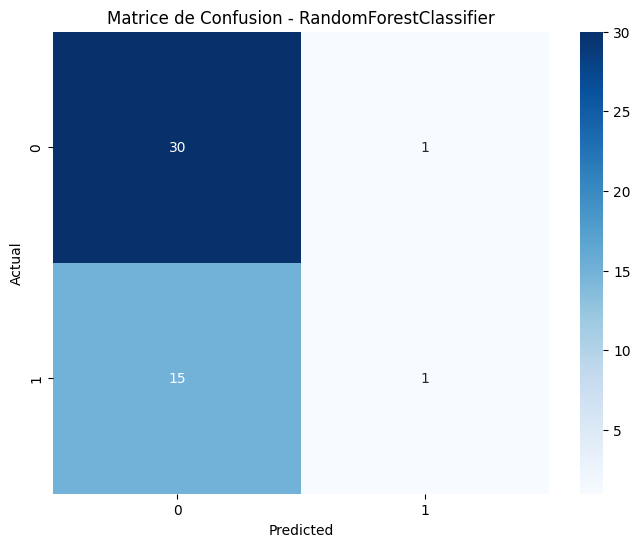

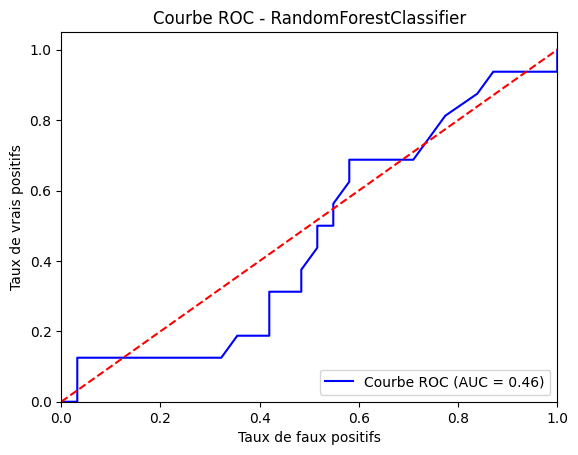

Métriques sur le test :
{'Best Model': 'RandomForestClassifier', 'Test Accuracy': 0.6595744680851063, 'Test Sensitivity': 0.0625, 'Test F1 Score': 0.1111111111111111, 'Test Specificity': 0.967741935483871, 'Test AUC': 0.4637096774193548}
Meilleur modèle: RandomForestClassifier
Tous les résultats ont été sauvegardés.


In [113]:

# Charger le dataset
data = pd.read_pickle('KFold/UG/combined_classes_0_1_strongest_coughs.pkl')

# Filtrer les classes
class_0 = data[data['tb_status'] == 0]
class_1 = data[data['tb_status'] == 1]

# Diviser chaque classe en ensembles d'entraînement (80%) et de test (20%)
class_0_train, class_0_test = train_test_split(class_0, test_size=0.2, random_state=42)
class_1_train, class_1_test = train_test_split(class_1, test_size=0.2, random_state=42)

# Combiner les ensembles d'entraînement
train_set = pd.concat([class_0_train, class_1_train], ignore_index=True)
test_set = pd.concat([class_0_test, class_1_test], ignore_index=True)

# Calculer les poids de classe
class_weights = compute_class_weight('balanced', classes=np.unique(train_set['tb_status']), y=train_set['tb_status'])
class_weight_dict = dict(enumerate(class_weights))

# Préparer les données d'entraînement
X_train = train_set.drop(['tb_status', 'participant_record_toux', 'Country'], axis=1).apply(pd.to_numeric).values
y_train = train_set['tb_status']

# Modèles à tester
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "SVM": SVC(probability=True, random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced')
}

best_model = None
best_auc = 0
results = []
all_fold_metrics = []

# K-Fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    fold_results = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_val = y_train[train_index], y_train[val_index]

        # Entraîner le modèle
        model.fit(X_fold_train, y_fold_train)

        # Évaluer le modèle
        y_val_prob = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_val_prob)
        fold_results.append(auc_score)

    # Calculer la moyenne des résultats des folds
    mean_auc = np.mean(fold_results)
    results.append({'Algorithm': model_name, 'Mean AUC': mean_auc})
    
    # Sauvegarder les résultats de chaque fold
    for fold_index, auc in enumerate(fold_results):
        all_fold_metrics.append({'Algorithm': model_name, 'Fold': fold_index + 1, 'AUC': auc})

    # Réentraînement final sur toutes les données d'entraînement
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_model = model

# Réentraîner le meilleur modèle sur toutes les données d'entraînement
best_model.fit(X_train, y_train)

# Préparer les données de test
X_test = test_set.drop(['tb_status', 'participant_record_toux', 'Country'], axis=1).apply(pd.to_numeric).values
y_test = test_set['tb_status']

# Prédire avec le meilleur modèle
y_pred_test = best_model.predict(X_test)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

# Calculer les métriques sur le test
test_accuracy = accuracy_score(y_test, y_pred_test)
test_sensitivity = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
test_specificity = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0
test_auc = roc_auc_score(y_test, y_prob_test)

# Créer un DataFrame pour les métriques de test
predictions_metrics_df = pd.DataFrame({
    'Model': [best_model.__class__.__name__] * 5,  # Répéter le nom du modèle pour chaque métrique
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'Specificity', 'AUC'],
    'Value': [test_accuracy, test_sensitivity, test_f1, test_specificity, test_auc]
})

# Sauvegarder les métriques de test dans un fichier CSV
predictions_file_path = 'Metrics/UG/ML/Predictions_Metrics_ML.csv'
os.makedirs(os.path.dirname(predictions_file_path), exist_ok=True)
predictions_metrics_df.to_csv(predictions_file_path, index=False)

# Sauvegarder les résultats des folds
all_fold_metrics_df = pd.DataFrame(all_fold_metrics)
cols = ['Fold'] + [col for col in all_fold_metrics_df.columns if col != 'Fold']
all_fold_metrics_df = all_fold_metrics_df[cols]
all_fold_metrics_file_path = 'Metrics/UG/ML/All_Fold_Metrics_Models.csv'
os.makedirs(os.path.dirname(all_fold_metrics_file_path), exist_ok=True)
all_fold_metrics_df.to_csv(all_fold_metrics_file_path, index=False)

# Sauvegarder le meilleur modèle et ses métriques
best_model_metrics = {
    'Best Model': best_model.__class__.__name__,
    'Test Accuracy': test_accuracy,
    'Test Sensitivity': test_sensitivity,
    'Test F1 Score': test_f1,
    'Test Specificity': test_specificity,
    'Test AUC': test_auc
}
best_model_metrics_df = pd.DataFrame([best_model_metrics])

# Sauvegarder les métriques du meilleur modèle
best_model_file_path = 'Metrics/UG/ML/best_Fold_Model.csv'
best_model_metrics_df.to_csv(best_model_file_path, index=False)

# Matrice de confusion
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Matrice de Confusion - ' + best_model.__class__.__name__)
plt.savefig(os.path.join('Metrics/UG/ML', 'Confusion_Matrix_Best_Model.png'))
plt.show()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - ' + best_model.__class__.__name__)
plt.legend(loc='lower right')
plt.savefig(os.path.join('Metrics/UG/ML', 'ROC_Curve_Best_Model.png'))
plt.show()

# Afficher les résultats
print("Métriques sur le test :")
print(best_model_metrics)

print(f"Meilleur modèle: {best_model.__class__.__name__}")

print("Tous les résultats ont été sauvegardés.")

### Afficher les 4 courbes ROC ensemble

In [101]:
data = pd.read_pickle('KFold/UG/combined_classes_0_1_strongest_coughs.pkl') #*****************
data

,participant_record_toux,Country,tb_status,strongest_energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_1_normalized,mfcc_2_normalized,mfcc_3_normalized,mfcc_4_normalized,mfcc_5_normalized,mfcc_6_normalized,mfcc_7_normalized,mfcc_8_normalized,mfcc_9_normalized,mfcc_10_normalized,mfcc_11_normalized,mfcc_12_normalized,mfcc_13_normalized
0,CODA_TB_0001_9_18,UG,0,40216419,-220.745895,65.829254,27.011854,32.761227,-23.230591,11.314826,22.190041,-6.510594,-3.283910,-12.727584,7.164924,1.887657,9.859139,0.000000,1.0,0.864547,0.884610,0.689227,0.809773,0.847722,0.747571,0.758831,0.725877,0.795292,0.776877,0.804693
1,CODA_TB_0011_5_5,UG,0,13471828,-61.996227,55.340965,-21.611328,7.559262,-9.489150,13.779888,0.610261,-13.985180,-12.915201,-16.537085,-10.976508,-3.035913,-2.867517,0.000000,1.0,0.344178,0.592783,0.447489,0.645798,0.533561,0.409172,0.418290,0.387423,0.434813,0.502486,0.503921
2,CODA_TB_0018_9_10,UG,0,50853580,-350.126556,67.668709,33.078777,37.212849,-5.730752,32.477695,12.558567,-17.811426,11.546260,1.560067,10.436554,-0.891345,-1.222140,0.000000,1.0,0.917208,0.927103,0.824317,0.915770,0.868093,0.795402,0.865670,0.841768,0.863014,0.835900,0.835109
3,CODA_TB_0021_9_11,UG,0,2586672,-2.245431,75.453865,1.373208,-3.373594,1.108434,11.257644,0.697173,0.098171,-10.297005,3.201377,4.089149,-9.107693,3.823714,0.093895,1.0,0.136094,0.080739,0.133007,0.251364,0.128211,0.121225,0.000000,0.157414,0.167767,0.013869,0.164671
4,CODA_TB_0029_9_17,UG,0,38475803,-173.495453,79.877594,-24.143217,0.552219,-4.273500,-1.216777,7.410943,-8.154237,-16.898289,-10.102185,-1.079619,8.105066,-4.580686,0.000000,1.0,0.589456,0.686923,0.667877,0.679941,0.713992,0.652560,0.618050,0.644872,0.680482,0.716732,0.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,CODA_TB_1032_9_22,UG,1,13048437,-71.781937,91.396912,-24.316805,12.958875,-5.928535,26.488934,-1.304262,-6.314064,-7.221372,-4.162986,4.019858,-3.794227,-0.755389,0.000000,1.0,0.290878,0.519312,0.403566,0.602228,0.431904,0.401203,0.395643,0.414385,0.464532,0.416645,0.435268
229,CODA_TB_1052_5_5,UG,1,6002372,-75.991425,108.758179,1.059316,16.868231,12.099725,7.919398,-5.115079,1.413182,3.476377,-7.533903,-4.417161,3.649405,-7.474247,0.000000,1.0,0.417055,0.502624,0.476814,0.454187,0.383635,0.418970,0.430138,0.370542,0.387412,0.431074,0.370865
230,CODA_TB_1073_5_5,UG,1,14529179,-119.613525,98.071022,0.669833,9.509688,-8.075621,13.266672,9.420244,1.026639,2.916972,-1.408639,-2.431271,7.002667,6.386781,0.000000,1.0,0.552558,0.593167,0.512383,0.610426,0.592756,0.554197,0.562881,0.543010,0.538312,0.581650,0.578821
231,CODA_TB_1084_9_15,UG,1,37803763,-226.705368,45.667362,20.741600,31.650160,6.060838,24.900785,6.539100,-13.371728,14.886567,-18.826042,8.673158,6.198038,-4.086106,0.000000,1.0,0.908487,0.948537,0.854587,0.923757,0.856343,0.783242,0.886990,0.763216,0.864178,0.855091,0.817333


########################################################################################################

## Préparation des données pour le développement des Modéles 

In [102]:
# Charger le DataFrame à partir du fichier pickle**********************  VN
combined_classes_0_1_strongest_coughs = pd.read_pickle('KFold/UG/combined_classes_0_1_strongest_coughs.pkl') #**********

# Afficher les 5 premières lignes du DataFrame
combined_classes_0_1_strongest_coughs

,participant_record_toux,Country,tb_status,strongest_energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_1_normalized,mfcc_2_normalized,mfcc_3_normalized,mfcc_4_normalized,mfcc_5_normalized,mfcc_6_normalized,mfcc_7_normalized,mfcc_8_normalized,mfcc_9_normalized,mfcc_10_normalized,mfcc_11_normalized,mfcc_12_normalized,mfcc_13_normalized
0,CODA_TB_0001_9_18,UG,0,40216419,-220.745895,65.829254,27.011854,32.761227,-23.230591,11.314826,22.190041,-6.510594,-3.283910,-12.727584,7.164924,1.887657,9.859139,0.000000,1.0,0.864547,0.884610,0.689227,0.809773,0.847722,0.747571,0.758831,0.725877,0.795292,0.776877,0.804693
1,CODA_TB_0011_5_5,UG,0,13471828,-61.996227,55.340965,-21.611328,7.559262,-9.489150,13.779888,0.610261,-13.985180,-12.915201,-16.537085,-10.976508,-3.035913,-2.867517,0.000000,1.0,0.344178,0.592783,0.447489,0.645798,0.533561,0.409172,0.418290,0.387423,0.434813,0.502486,0.503921
2,CODA_TB_0018_9_10,UG,0,50853580,-350.126556,67.668709,33.078777,37.212849,-5.730752,32.477695,12.558567,-17.811426,11.546260,1.560067,10.436554,-0.891345,-1.222140,0.000000,1.0,0.917208,0.927103,0.824317,0.915770,0.868093,0.795402,0.865670,0.841768,0.863014,0.835900,0.835109
3,CODA_TB_0021_9_11,UG,0,2586672,-2.245431,75.453865,1.373208,-3.373594,1.108434,11.257644,0.697173,0.098171,-10.297005,3.201377,4.089149,-9.107693,3.823714,0.093895,1.0,0.136094,0.080739,0.133007,0.251364,0.128211,0.121225,0.000000,0.157414,0.167767,0.013869,0.164671
4,CODA_TB_0029_9_17,UG,0,38475803,-173.495453,79.877594,-24.143217,0.552219,-4.273500,-1.216777,7.410943,-8.154237,-16.898289,-10.102185,-1.079619,8.105066,-4.580686,0.000000,1.0,0.589456,0.686923,0.667877,0.679941,0.713992,0.652560,0.618050,0.644872,0.680482,0.716732,0.666664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,CODA_TB_1032_9_22,UG,1,13048437,-71.781937,91.396912,-24.316805,12.958875,-5.928535,26.488934,-1.304262,-6.314064,-7.221372,-4.162986,4.019858,-3.794227,-0.755389,0.000000,1.0,0.290878,0.519312,0.403566,0.602228,0.431904,0.401203,0.395643,0.414385,0.464532,0.416645,0.435268
229,CODA_TB_1052_5_5,UG,1,6002372,-75.991425,108.758179,1.059316,16.868231,12.099725,7.919398,-5.115079,1.413182,3.476377,-7.533903,-4.417161,3.649405,-7.474247,0.000000,1.0,0.417055,0.502624,0.476814,0.454187,0.383635,0.418970,0.430138,0.370542,0.387412,0.431074,0.370865
230,CODA_TB_1073_5_5,UG,1,14529179,-119.613525,98.071022,0.669833,9.509688,-8.075621,13.266672,9.420244,1.026639,2.916972,-1.408639,-2.431271,7.002667,6.386781,0.000000,1.0,0.552558,0.593167,0.512383,0.610426,0.592756,0.554197,0.562881,0.543010,0.538312,0.581650,0.578821
231,CODA_TB_1084_9_15,UG,1,37803763,-226.705368,45.667362,20.741600,31.650160,6.060838,24.900785,6.539100,-13.371728,14.886567,-18.826042,8.673158,6.198038,-4.086106,0.000000,1.0,0.908487,0.948537,0.854587,0.923757,0.856343,0.783242,0.886990,0.763216,0.864178,0.855091,0.817333


In [103]:
# 'classement_toux' à déplacer en 2eme position
combined_data['classement_toux'] = combined_data.groupby('participant').cumcount() + 1
col_to_move2 = 'classement_toux'
columns_2 = [col for col in combined_data.columns if col != col_to_move2]
columns_2.insert(2, col_to_move2)
combined_data = combined_data[columns_2]

# 'total_des_toux' à déplacer en 3eme position
combined_data['total_des_toux'] = combined_data.groupby('participant')['reported_cough_dur'].transform('count')
col_to_move = 'total_des_toux'
columns = [col for col in combined_data.columns if col != col_to_move]
columns.insert(3, col_to_move)
combined_data = combined_data[columns]

#---------------------------------------------------------------------------------------------------

#combined_data['classement_total_participant'] = combined_data['classement_toux'].astype(str) + 'sur' + combined_data['total_des_toux'].astype(str)
combined_data.loc[:, 'classement_total_participant'] = combined_data['classement_toux'].astype(str) + '_' + combined_data['total_des_toux'].astype(str)


# 'classement_total_participant' à déplacer en 1ere position
####df['classement_total_participant'] = df.groupby('participant')['reported_cough_dur'].transform('count')
col_to_move1 = 'classement_total_participant'
columns_1 = [col for col in combined_data.columns if col != col_to_move1]
columns_1.insert(1, col_to_move1)
combined_data = combined_data[columns_1]

#---------------------------------------------------------------------------------------------------

# Concaténer les colonnes avec un '/' comme séparateur
#combined_data['participant_palmares_toux'] = combined_data['participant'].astype(str) + '_' + combined_data['classement_total_participant'].astype(str)
combined_data.loc[:, 'participant_record_toux'] = combined_data['participant'].astype(str) + '_' + combined_data['classement_total_participant'].astype(str)


# 'classement_total_participant' à déplacer en 1ere position
####df['classement_total_participant'] = df.groupby('participant')['reported_cough_dur'].transform('count')
col_to_move4 = 'participant_record_toux'
columns_4 = [col for col in combined_data.columns if col != col_to_move4]
columns_4.insert(1, col_to_move4)
combined_data = combined_data[columns_4]

# Créer le dossier s'il n'existe pas** 
#os.makedirs('Spectogram_File', exist_ok=True)
#combined_data.to_pickle('Spectogram_File/VN/combined_data_participant_record_toux.pkl')


# Définir le chemin
directory = 'Spectogram_File/UG' #***************************************************************************************
# Créer le dossier s'il n'existe pas
os.makedirs(directory, exist_ok=True)
# Ensuite, sauvegarde ton fichier dans ce répertoire
#data.to_pickle(os.path.join(directory, 'combined_data_participant_record_toux.pkl'))
combined_data.to_pickle(os.path.join(directory, 'combined_data_participant_record_toux.pkl'))



print("Dataset sauvegardé avec succès au format pickle.")


#combined_data.head()

Dataset sauvegardé avec succès au format pickle.


### Sauvegarder ce dataset

 avec la colonne participant_record_toux

In [104]:
# Charger le DataFrame à partir du fichier pickle
combined_data_participant_record_toux = pd.read_pickle('Spectogram_File/UG/combined_data_participant_record_toux.pkl') #***********

# Afficher le contenu du DataFrame
combined_data_participant_record_toux.head(2)

,participant,participant_record_toux,classement_total_participant,classement_toux,total_des_toux,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status,Country,Numberofcoughsoundscollected,HIVstatus,Microbiologicreferencestandard,Sputumxpertreferencestandard,Xpertcombinedsemiquant,sound_prediction_score,audio_signal,mfcc,mfcc_shape,mfcc_count
0,CODA_TB_0001,CODA_TB_0001_1_18,1_18,1,18,Male,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990254,"[518, 408, 353, 359, 350, 374, 304, 336, 345, ...","[[-392.96967, -411.3173, -456.14334, -477.0735...","(13, 44)",572
1,CODA_TB_0001,CODA_TB_0001_2_18,2_18,2,18,Male,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0,UG,18,Negative,Negative,Negative,High,0.990272,"[773, 773, 794, 808, 784, 753, 740, 744, 764, ...","[[-369.39105, -409.0158, -447.3704, -464.0849,...","(13, 44)",572


### Rajouter la colonne audio_signal

In [105]:
# Charger les datasets
combined_data_participant_record_toux = pd.read_pickle('Spectogram_File/UG/combined_data_participant_record_toux.pkl') #****
combined_classes_0_1_strongest_coughs = pd.read_pickle('KFold/UG/combined_classes_0_1_strongest_coughs.pkl') #***********

# Fusionner les deux datasets sur la colonne 'participant_record_toux'
merged_data = combined_classes_0_1_strongest_coughs.merge(
    combined_data[['participant_record_toux', 'audio_signal']],  # Garder seulement audio_signal
    on='participant_record_toux',  # La colonne sur laquelle faire la jointure
    how='left'  # Garder toutes les entrées du dataset de gauche
)

# Sauvegarder le dataset fusionné si nécessaire
merged_data.to_pickle('Spectogram_File/UG/combined_classes_0_1_strongest_coughs_audio_signal.pkl') #*********************

print("Colonne audio_signal ajoutée avec succès.")

Colonne audio_signal ajoutée avec succès.


In [106]:
# Specify the path to your pickle file #*********************************************
combined_classes_0_1_strongest_coughs_audio_signal = pd.read_pickle('Spectogram_File/UG/combined_classes_0_1_strongest_coughs_audio_signal.pkl')

# Load the DataFrame from the pickle file
combined_classes_0_1_strongest_coughs_audio_signal 

,participant_record_toux,Country,tb_status,strongest_energy,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_1_normalized,mfcc_2_normalized,mfcc_3_normalized,mfcc_4_normalized,mfcc_5_normalized,mfcc_6_normalized,mfcc_7_normalized,mfcc_8_normalized,mfcc_9_normalized,mfcc_10_normalized,mfcc_11_normalized,mfcc_12_normalized,mfcc_13_normalized,audio_signal
0,CODA_TB_0001_9_18,UG,0,40216419,-220.745895,65.829254,27.011854,32.761227,-23.230591,11.314826,22.190041,-6.510594,-3.283910,-12.727584,7.164924,1.887657,9.859139,0.000000,1.0,0.864547,0.884610,0.689227,0.809773,0.847722,0.747571,0.758831,0.725877,0.795292,0.776877,0.804693,"[357, 371, 330, 241, 263, 320, 280, 267, 279, ..."
1,CODA_TB_0011_5_5,UG,0,13471828,-61.996227,55.340965,-21.611328,7.559262,-9.489150,13.779888,0.610261,-13.985180,-12.915201,-16.537085,-10.976508,-3.035913,-2.867517,0.000000,1.0,0.344178,0.592783,0.447489,0.645798,0.533561,0.409172,0.418290,0.387423,0.434813,0.502486,0.503921,"[-628, -721, -806, -727, -621, -473, -548, -60..."
2,CODA_TB_0018_9_10,UG,0,50853580,-350.126556,67.668709,33.078777,37.212849,-5.730752,32.477695,12.558567,-17.811426,11.546260,1.560067,10.436554,-0.891345,-1.222140,0.000000,1.0,0.917208,0.927103,0.824317,0.915770,0.868093,0.795402,0.865670,0.841768,0.863014,0.835900,0.835109,"[190, 216, 198, 161, 153, 145, 166, 161, 184, ..."
3,CODA_TB_0021_9_11,UG,0,2586672,-2.245431,75.453865,1.373208,-3.373594,1.108434,11.257644,0.697173,0.098171,-10.297005,3.201377,4.089149,-9.107693,3.823714,0.093895,1.0,0.136094,0.080739,0.133007,0.251364,0.128211,0.121225,0.000000,0.157414,0.167767,0.013869,0.164671,"[2050, 2046, 3543, 3173, 2109, 346, 1378, 3346..."
4,CODA_TB_0029_9_17,UG,0,38475803,-173.495453,79.877594,-24.143217,0.552219,-4.273500,-1.216777,7.410943,-8.154237,-16.898289,-10.102185,-1.079619,8.105066,-4.580686,0.000000,1.0,0.589456,0.686923,0.667877,0.679941,0.713992,0.652560,0.618050,0.644872,0.680482,0.716732,0.666664,"[56, 9, -48, -54, -44, -55, -69, -96, -102, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,CODA_TB_1032_9_22,UG,1,13048437,-71.781937,91.396912,-24.316805,12.958875,-5.928535,26.488934,-1.304262,-6.314064,-7.221372,-4.162986,4.019858,-3.794227,-0.755389,0.000000,1.0,0.290878,0.519312,0.403566,0.602228,0.431904,0.401203,0.395643,0.414385,0.464532,0.416645,0.435268,"[669, 726, 807, 891, 879, 706, 685, 710, 679, ..."
229,CODA_TB_1052_5_5,UG,1,6002372,-75.991425,108.758179,1.059316,16.868231,12.099725,7.919398,-5.115079,1.413182,3.476377,-7.533903,-4.417161,3.649405,-7.474247,0.000000,1.0,0.417055,0.502624,0.476814,0.454187,0.383635,0.418970,0.430138,0.370542,0.387412,0.431074,0.370865,"[484, 488, 450, -18, -224, -420, -780, -1024, ..."
230,CODA_TB_1073_5_5,UG,1,14529179,-119.613525,98.071022,0.669833,9.509688,-8.075621,13.266672,9.420244,1.026639,2.916972,-1.408639,-2.431271,7.002667,6.386781,0.000000,1.0,0.552558,0.593167,0.512383,0.610426,0.592756,0.554197,0.562881,0.543010,0.538312,0.581650,0.578821,"[445, 488, 654, 741, 769, 814, 865, 882, 831, ..."
231,CODA_TB_1084_9_15,UG,1,37803763,-226.705368,45.667362,20.741600,31.650160,6.060838,24.900785,6.539100,-13.371728,14.886567,-18.826042,8.673158,6.198038,-4.086106,0.000000,1.0,0.908487,0.948537,0.854587,0.923757,0.856343,0.783242,0.886990,0.763216,0.864178,0.855091,0.817333,"[-96, -89, -92, -87, -103, -93, -91, -81, -103..."


## 1.5 Sauvegarder les Log Mel Spectogram

In [107]:
#******************************************************************************************************
import cv2
# Définir le code du pays ici
country_name = 'UG'  # Remplacez par le code du pays souhaité *************************

data = pd.read_pickle('Spectogram_File/UG/combined_classes_0_1_strongest_coughs_audio_signal.pkl') #******************

# Filtrer les classes
class_0 = data[data['tb_status'] == 0]
class_1 = data[data['tb_status'] == 1]

def generate_and_save_log_mel_spectrogram(audio_signal, file_name, label, sr=44100, target_shape=(64, 64)):
    # Vérifier et convertir en float32 si nécessaire
    if audio_signal.dtype != np.float32:
        audio_signal = audio_signal.astype(np.float32)
    
    # Normaliser le signal
    audio_signal /= np.max(np.abs(audio_signal))  # Normalisation entre -1 et 1

    # Générer le spectrogramme Mel
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_mels=128)
    
    # Convertir en échelle logarithmique (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Redimensionner l'image
    log_mel_spectrogram_resized = cv2.resize(log_mel_spectrogram, target_shape)

    # Créer une figure pour le spectrogramme
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spectrogram_resized, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel Spectrogram')

    # Créer le dossier de sortie--------------------------------------------------------------
    output_dir = f'classe_{label}/{country_name}/UG_Log_Mel_Spectogram' #**************************
    os.makedirs(output_dir, exist_ok=True)

    # Sauvegarder l'image dans le dossier correspondant à la classe
    plt.savefig(os.path.join(output_dir, f"{file_name}.png"))  # Sauvegarde en PNG
    plt.close()  # Fermer la figure pour libérer la mémoire

# Mesurer le temps d'exécution
start_time = time.time()

# Chargement des données
for index, row in data.iterrows():
    audio_signal = row['audio_signal']  # Signal audio
    participant_record_toux = row['participant_record_toux']  # Récupérer le participant
    country = row['Country']  # Récupérer le pays
    tb_status = row['tb_status']  # Récupérer le statut(0 ou 1)

    # Vérifier si le pays correspond à l'entrée de l'utilisateur
    if country == country_name:
        # Créer le nom de fichier selon le format souhaité
        file_name = f"{index}_{participant_record_toux}_{country}_{tb_status}"
        
        # Générer et sauvegarder le log Mel spectrogramme
        generate_and_save_log_mel_spectrogram(audio_signal, file_name, tb_status)

end_time = time.time()  # Temps de fin
execution_time = end_time - start_time  # Calculer le temps d'exécution

print(f"Log Mel spectrogrammes sauvegardés avec succès.")
print(f"Temps d'exécution : {execution_time:.2f} secondes")

Log Mel spectrogrammes sauvegardés avec succès.
Temps d'exécution : 58.15 secondes


In [108]:
#**************************************************************************************************************

## 2.1 CNN avec Stratified KFold Cross Validation

Cela impliquera de diviser les données d'entraînement en plusieurs plis (folds), d'entraîner le modèle sur chaque pli et d'évaluer les performances sur un ensemble de validation.

- Vérifiez la taille de votre array : Assurez-vous que le nombre total d'éléments dans X_train et X_test est un multiple de 64 * 64 * 3. Par exemple, pour un spectrogramme de 64x64 avec 3 canaux, vous avez besoin de 64 * 64 * 3 = 12288 éléments par échantillon.

- Ajustez le reshape : Assurez-vous que votre reshape est compatible avec le nombre d'échantillons.

Le problème indique que les données dans X_train n'ont pas la forme attendue pour le reshape. Pour corriger cela, vous devez d'abord vérifier comment les données sont générées dans X_train.

Assurez-vous que les spectrogrammes que vous extrayez ont bien la forme (64, 64, 3) avant de tenter le reshape

Le fait que X_train ait une forme de (128, 28) indique que vos données n'ont pas la structure attendue pour les spectrogrammes. Voici comment vous pouvez corriger cela :

Vérifiez l'extraction des caractéristiques : Assurez-vous que lorsque vous créez X_train, vous extrayez effectivement les spectrogrammes sous la forme souhaitée (64, 64, 3).

Modification de l'extraction des données : Lors de la création de X_train, utilisez une méthode pour vous assurer que vous obtenez des images de taille correcte. Par exemple, cela pourrait ressembler à :


L'erreur que vous rencontrez est liée à la forme des entrées du modèle. Le modèle s'attend à des entrées de forme (None, None, 64, 64, 1), mais reçoit (16, 64, 64, 1).

Voici les modifications nécessaires pour corriger cela :

Supprimer TimeDistributed : Si vous n'utilisez pas de séquences temporelles (par exemple, si chaque entrée est un seul spectrogramme), vous n'avez pas besoin d'une couche TimeDistributed.

In [109]:
#-1 Chargement des données
#-2 Filtrer les classes
#-3 Diviser chaque classe en ensembles d'entraînement (80%) et de test (20%)
#-4 Combiner les ensembles d'entraînement
#-5 Fonction pour générer un spectrogramme
#-6 Préparation des données
#-7 Initialiser StratifiedKFold
#-8 Liste pour stocker les résultats et les indices de folds
#-9 Créer le modèle CNN
#-10 Compiler et entraîner le modèle
#-11 Évaluer le modèle
#-12 Calculer les métriques
#-13 Afficher le meilleur fold-------------
#-14 Obtenir les indices du meilleur fold
#-15 Préparer les données du meilleur fold pour les prédictions
#-16 Sauvegarder les données du meilleur fold
#-17 Préparation des données de test
#-18 Entraîner le modèle sur le meilleur fold
#-19 Prédictions sur le jeu de test
#-20 Calculer les métriques sur le jeu de test
#-21 Afficher les résultats
#-22 Enregistrer les métriques dans un fichier CSV


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5252 - loss: 3.2447 - val_accuracy: 0.6579 - val_loss: 2.0742
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5646 - loss: 1.2924 - val_accuracy: 0.6579 - val_loss: 0.8933
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6862 - loss: 0.8300 - val_accuracy: 0.6579 - val_loss: 1.2805
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6821 - loss: 0.6500 - val_accuracy: 0.6579 - val_loss: 0.7883
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6670 - loss: 0.7785 - val_accuracy: 0.6579 - val_loss: 1.9667
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7432 - loss: 0.6998 - val_accuracy: 0.6053 - val_loss: 0.9014
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6044 - loss: 0.6365 - val_accuracy: 0.6579 - val_loss: 0.8280
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8091 - loss: 0.4315 - val_accuracy: 0.6842 - 

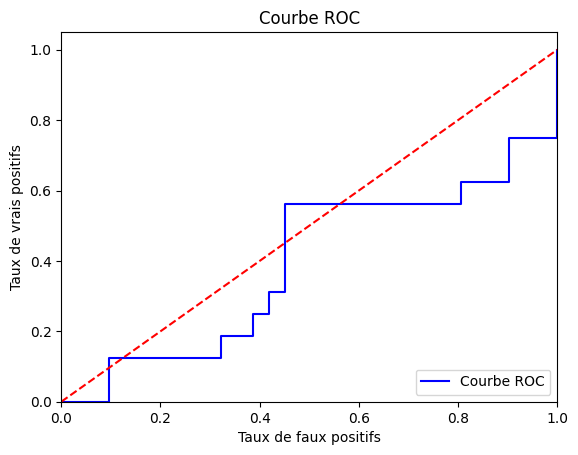

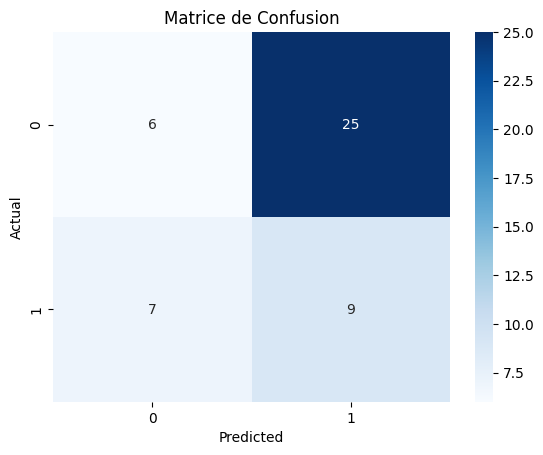

In [110]:

country = 'UG'

def save_metrics_and_plot(country):
    metrics_dir = f'Metrics/{country}/CNN'
    os.makedirs(metrics_dir, exist_ok=True)

    # Charger les données
    data = pd.read_pickle('Spectogram_File/UG/combined_classes_0_1_strongest_coughs_audio_signal.pkl')
    class_0 = data[data['tb_status'] == 0]
    class_1 = data[data['tb_status'] == 1]

    class_0_train, class_0_test = train_test_split(class_0, test_size=0.2, random_state=42)
    class_1_train, class_1_test = train_test_split(class_1, test_size=0.2, random_state=42)

    train_set = pd.concat([class_0_train, class_1_train], ignore_index=True)
    test_set = pd.concat([class_0_test, class_1_test], ignore_index=True)

    def generate_spectrogram(audio_signal, sr=44100):
        audio_signal = audio_signal.astype(np.float32)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return cv2.resize(log_mel_spectrogram, (64, 64))

    X, y = [], []
    for _, row in train_set.iterrows():
        audio_signal = row['audio_signal']
        spectrogram = generate_spectrogram(audio_signal)
        if spectrogram.shape == (64, 64):
            X.append(spectrogram)
            y.append(row['tb_status'])

    X = np.array(X).reshape((-1, 64, 64, 1))
    y = np.array(y)

    # Calculer les poids des classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics_list, fold_indices = [], []

    for train_index, val_index in skf.split(X, y):
        fold_indices.append((train_index, val_index))
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Entraîner le modèle avec class_weight
        model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weight_dict)

        # Évaluer le modèle
        loss, accuracy = model.evaluate(X_val, y_val)
        y_pred_prob = model.predict(X_val).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Calcul des métriques
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        roc_auc = roc_auc_score(y_val, y_pred_prob)

        metrics_list.append({
            'Fold': len(metrics_list) + 1,
            'Model': 'CNN',  # Ajouter le nom du modèle
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1,
            'Specificity': specificity,
            'AUC-ROC': roc_auc
        })

    # Sauvegarder les résultats des folds
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(os.path.join(metrics_dir, f'All_Folds_Metrics_CNN_{country}.csv'), index=False)

    # Calcul de la moyenne de AUC
    mean_auc = metrics_df['AUC-ROC'].mean()

    # Sélection du meilleur fold
    best_fold = metrics_df.loc[metrics_df['AUC-ROC'].idxmax()]
    best_fold_metrics = best_fold.to_dict()

    # Sauvegarder le meilleur modèle
    best_fold_metrics['Fold'] = best_fold['Fold']  # Ajouter le numéro du fold
    best_fold_metrics['Model'] = 'CNN'  # Ajouter le nom du modèle
    best_model_metrics_df = pd.DataFrame([best_fold_metrics])
    best_model_file_path = os.path.join(metrics_dir, 'best_Fold_Model.csv')
    best_model_metrics_df.to_csv(best_model_file_path, index=False)

    print(f"Meilleur Fold: {best_fold['Fold']}")
    print(best_fold)

    # Préparer les données de test
    X_test, y_test = [], []
    for _, row in test_set.iterrows():
        audio_signal = row['audio_signal']
        spectrogram = generate_spectrogram(audio_signal)
        if spectrogram.shape == (64, 64):
            X_test.append(spectrogram)
            y_test.append(row['tb_status'])

    X_test = np.array(X_test).reshape((-1, 64, 64, 1))
    y_test = np.array(y_test)

    # Entraîner le modèle final sur toutes les données d'entraînement
    model.fit(X, y, epochs=10, batch_size=16, class_weight=class_weight_dict)

    # Prédire sur l'ensemble de test
    y_pred_prob_test = model.predict(X_test).ravel()
    y_pred_test = (y_pred_prob_test > 0.5).astype(int)

    # Évaluer les performances sur l'ensemble de test
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)  # Ajouter l'accuracy
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0
    roc_auc_test = roc_auc_score(y_test, y_pred_prob_test)

    # Créer un DataFrame pour les métriques de test
    test_metrics = pd.DataFrame({
        'Metric': ['Model', 'Accuracy', 'Recall', 'F1 Score', 'Specificity', 'AUC-ROC'],
        'Value': ['CNN', accuracy_test, recall_test, f1_test, specificity_test, roc_auc_test]
    })
    test_metrics.to_csv(os.path.join(metrics_dir, f'Predictions_Metrics_CNN_{country}.csv'), index=False)

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='Courbe ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(metrics_dir, f'ROC_Curve_CNN_{country}.png'))
    plt.show()

    # Sauvegarder la matrice de confusion
    plt.figure()
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Matrice de Confusion')
    plt.savefig(os.path.join(metrics_dir, f'Confusion_Matrix_CNN_{country}.png'))
    plt.show()

# Exemple d'utilisation
save_metrics_and_plot(country)

## 2.2 RNN LSTM avec Startified KFold Cross Validation

Modifications apportées :

-1 Suppression du CNN : Le code ne contient plus de couches CNN. L'architecture se compose uniquement de couches LSTM.
-2 Reshape pour LSTM : Les entrées sont préparées pour être compatibles avec le LSTM (échantillons, timesteps,   caractéristiques).
-3 Validation croisée stratifiée : Le code utilise toujours StratifiedKFold pour garantir que chaque fold conserve la proportion des classes.
Ce code devrait te permettre d'utiliser des LSTM pour tes prédictions sur les données audio tout en maintenant une structure similaire à celle de ton code CNN.

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.4126 - loss: 0.7740 - val_accuracy: 0.6579 - val_loss: 0.6424
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6711 - loss: 0.6822 - val_accuracy: 0.5263 - val_loss: 0.6992
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4054 - loss: 0.6723 - val_accuracy: 0.3421 - val_loss: 0.7070
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.4133 - loss: 0.7099 - val_accuracy: 0.3421 - val_loss: 0.7265
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4184 - loss: 0.7082 - val_accuracy: 0.6579 - val_loss: 0.6578
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5667 - loss: 0.6873 - val_accuracy: 0.7368 - val_loss: 0.6834
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5012 - loss: 0.6771 - val_accuracy: 0.5789 - val_loss: 0.6886
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5070 - loss: 0.7043 - val_accuracy: 0.3421 - 

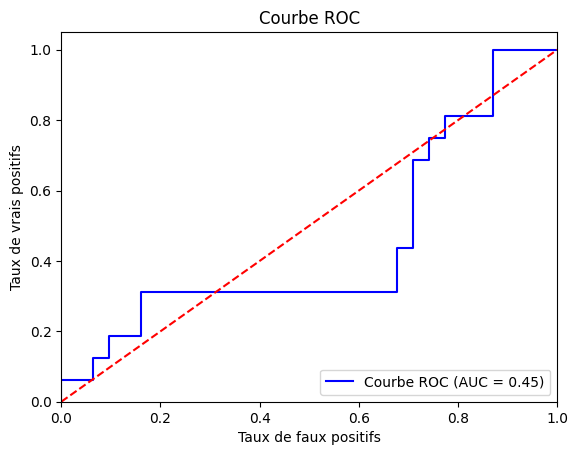

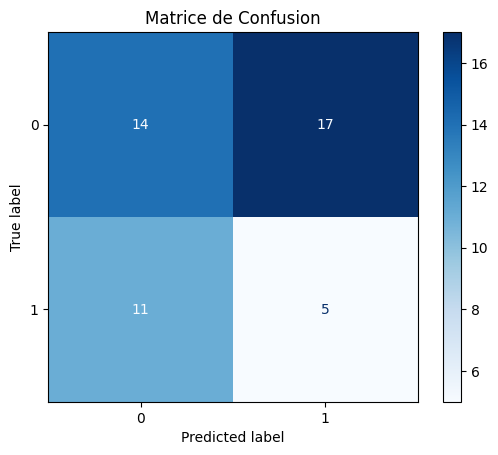

   Fold     Model  Accuracy    Recall  F1 Score  Specificity   AUC-ROC
0     1  RNN_LSTM  0.631579  0.153846  0.222222     0.880000  0.572308
1     2  RNN_LSTM  0.621622  0.000000  0.000000     0.920000  0.316667
2     3  RNN_LSTM  0.702703  0.750000  0.620690     0.680000  0.646667
3     4  RNN_LSTM  0.567568  0.500000  0.428571     0.600000  0.620000
4     5  RNN_LSTM  0.432432  0.692308  0.461538     0.291667  0.471154


In [111]:

country = 'UG'

def save_metrics_and_plot(country):
    metrics_dir = f'Metrics/{country}/RNN_LSTM'
    os.makedirs(metrics_dir, exist_ok=True)

    data = pd.read_pickle('Spectogram_File/UG/combined_classes_0_1_strongest_coughs_audio_signal.pkl')
    class_0 = data[data['tb_status'] == 0]
    class_1 = data[data['tb_status'] == 1]
    
    class_0_train, class_0_test = train_test_split(class_0, test_size=0.2, random_state=42)
    class_1_train, class_1_test = train_test_split(class_1, test_size=0.2, random_state=42)

    train_set = pd.concat([class_0_train, class_1_train], ignore_index=True)
    test_set = pd.concat([class_0_test, class_1_test], ignore_index=True)

    def generate_spectrogram(audio_signal, sr=44100):
        audio_signal = audio_signal.astype(np.float32)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return cv2.resize(log_mel_spectrogram, (64, 64))

    X, y = [], []
    for _, row in train_set.iterrows():
        audio_signal = row['audio_signal']
        spectrogram = generate_spectrogram(audio_signal)
        if spectrogram.shape == (64, 64):
            X.append(spectrogram)
            y.append(row['tb_status'])

    X = np.array(X).reshape((-1, 64, 64, 1))
    y = np.array(y)

    # Reshape pour LSTM (échantillons, timesteps, caractéristiques)
    X = X.reshape(X.shape[0], 64, 64)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics_list = []

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Calculer les poids de classe
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

        model = Sequential()
        model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        model.add(Dropout(0.25))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.25))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val), class_weight=class_weight_dict)

        loss, accuracy = model.evaluate(X_val, y_val)
        y_pred_prob = model.predict(X_val).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        roc_auc_val = roc_auc_score(y_val, y_pred_prob)

        metrics_list.append({
            'Fold': len(metrics_list) + 1,
            'Model': 'RNN_LSTM',
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1,
            'Specificity': specificity,
            'AUC-ROC': roc_auc_val
        })

    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(os.path.join(metrics_dir, f'All_Folds_Metrics_RNN_LSTM_{country}.csv'), index=False)

    best_fold = metrics_df.loc[metrics_df['AUC-ROC'].idxmax()]
    best_fold_metrics = best_fold.to_dict()
    best_fold_metrics['Fold'] = best_fold['Fold']
    best_fold_metrics['Model'] = 'RNN_LSTM'

    best_model_metrics_df = pd.DataFrame([best_fold_metrics])
    best_model_file_path = os.path.join(metrics_dir, 'best_Fold_Model.csv')
    best_model_metrics_df.to_csv(best_model_file_path, index=False)

    print(f"Meilleur Fold: {best_fold['Fold']}")
    print(best_fold)

    X_all_train = X
    y_all_train = y

    model.fit(X_all_train, y_all_train, epochs=10, batch_size=16, class_weight=class_weight_dict)

    X_test, y_test = [], []
    for _, row in test_set.iterrows():
        audio_signal = row['audio_signal']
        spectrogram = generate_spectrogram(audio_signal)
        if spectrogram.shape == (64, 64):
            X_test.append(spectrogram)
            y_test.append(row['tb_status'])

    X_test = np.array(X_test).reshape((-1, 64, 64))
    y_test = np.array(y_test)

    y_pred_prob_test = model.predict(X_test).ravel()
    y_pred_test = (y_pred_prob_test > 0.5).astype(int)

    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0
    roc_auc_test = roc_auc_score(y_test, y_pred_prob_test)

    test_metrics = pd.DataFrame({
        'Metric': ['Model', 'Accuracy', 'Recall', 'F1 Score', 'Specificity', 'AUC-ROC'],
        'Value': ['RNN_LSTM', accuracy_test, recall_test, f1_test, specificity_test, roc_auc_test]
    })
    test_metrics.to_csv(os.path.join(metrics_dir, f'Predictions_Metrics_RNN_LSTM_{country}.csv'), index=False)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
    roc_auc_final = roc_auc_score(y_test, y_pred_prob_test)  # Renommer ici

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc_final:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(metrics_dir, f'ROC_curve_RNN_LSTM_{country}.png'))
    plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion')
    plt.savefig(os.path.join(metrics_dir, f'Confusion_Matrix_RNN_LSTM_{country}.png'))
    plt.show()

    print(metrics_df)

# Exemple d'utilisation
save_metrics_and_plot(country)

* Stratégies pour améliorer la performance de tes métriques avec un modèle RNN LSTM, voici quelques stratégies :

1- Augmentation de données : Génère plus de données à partir de tes échantillons existants en appliquant des transformations comme des rotations, des zooms, ou des variations de volume.

2- Régularisation : Utilise des techniques comme le Dropout (déjà présent) et l'ajout de L2 regularization pour éviter le surapprentissage.

3- Optimisation des hyperparamètres : Explore des architectures différentes (nombre de couches, neurones par couche), des taux d'apprentissage variés, et des tailles de batch différentes. Utilise des outils comme GridSearchCV ou RandomizedSearchCV pour automatiser ce processus.

4- Ajustement du modèle : Essaie d'ajouter des couches supplémentaires, d'expérimenter avec des cellules LSTM bidirectionnelles, ou de tester d'autres types de RNN comme les GRU.

5- Normalisation des données : Assure-toi que tes données sont correctement normalisées, ce qui peut améliorer la convergence du modèle.

6- Ensembles de modèles : Combine les résultats de plusieurs modèles (par exemple, en utilisant un modèle LSTM et un modèle GRU ensemble) pour une meilleure robustesse.

7- Fine-tuning des modèles pré-entraînés : Si disponible, utilise des modèles pré-entraînés et adapte-les à ton problème spécifique.

8- Évaluation continue : Surveille les performances sur un ensemble de validation et ajuste ton modèle en conséquence.

## 2.3 CNN / LSTM

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5882 - loss: 0.7436 - val_accuracy: 0.6316 - val_loss: 0.6367
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6056 - loss: 0.6556 - val_accuracy: 0.6316 - val_loss: 0.6396
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8013 - loss: 0.5810 - val_accuracy: 0.6316 - val_loss: 0.6325
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7330 - loss: 0.6071 - val_accuracy: 0.6579 - val_loss: 0.6423
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8370 - loss: 0.5287 - val_accuracy: 0.7368 - val_loss: 0.6152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7621 - loss: 0.6019 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5654 - loss: 0.7035 - val_accuracy: 0.6486 - val_loss: 0.6596
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6573 - loss: 0.6549 - val_accuracy: 0.6486 - val_loss: 0.6566
Epoch 3/5
38

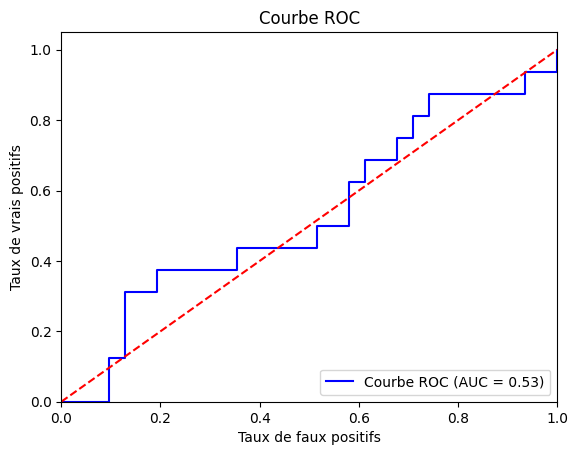

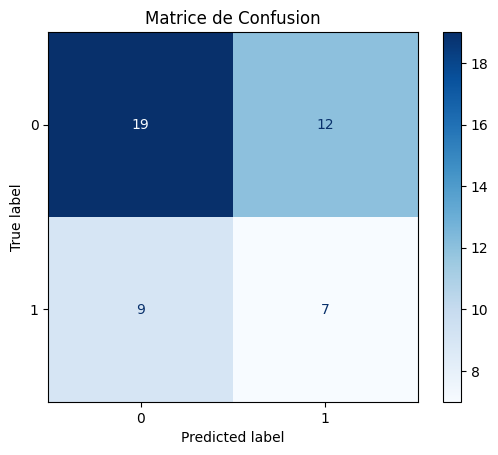

   Fold     Model  Accuracy    Recall  F1 Score  Specificity   AUC-ROC
0     1  CNN_LSTM  0.736842  0.384615  0.500000     0.920000  0.726154
1     2  CNN_LSTM  0.648649  0.250000  0.315789     0.840000  0.466667
2     3  CNN_LSTM  0.702703  0.166667  0.266667     0.960000  0.670000
3     4  CNN_LSTM  0.729730  0.416667  0.500000     0.880000  0.743333
4     5  CNN_LSTM  0.675676  0.384615  0.454545     0.833333  0.644231


In [112]:

country = 'UG'

def save_metrics_and_plot(country):
    metrics_dir = f'Metrics/{country}/CNN_LSTM'
    os.makedirs(metrics_dir, exist_ok=True)

    data = pd.read_pickle('Spectogram_File/UG/combined_classes_0_1_strongest_coughs_audio_signal.pkl')
    class_0 = data[data['tb_status'] == 0]
    class_1 = data[data['tb_status'] == 1]
    
    class_0_train, class_0_test = train_test_split(class_0, test_size=0.2, random_state=42)
    class_1_train, class_1_test = train_test_split(class_1, test_size=0.2, random_state=42)

    train_set = pd.concat([class_0_train, class_1_train], ignore_index=True)
    test_set = pd.concat([class_0_test, class_1_test], ignore_index=True)

    def generate_spectrogram(audio_signal, sr=44100):
        audio_signal = audio_signal.astype(np.float32)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        return cv2.resize(log_mel_spectrogram, (16, 16))

    X, y = [], []
    for _, row in train_set.iterrows():
        audio_signal = row['audio_signal']
        spectrogram = generate_spectrogram(audio_signal)
        if spectrogram.shape == (16, 16):
            X.append(spectrogram)
            y.append(row['tb_status'])

    X = np.array(X).reshape((-1, 1, 16, 16, 1))  # Ajouter une dimension temporelle
    y = np.array(y)

    # Normaliser les données
    X = (X - np.mean(X)) / np.std(X)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics_list = []
    best_auc = 0
    best_model_metrics = None

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Calculer les poids de classe
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = dict(enumerate(class_weights))

        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(1, 16, 16, 1)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Dropout(0.25)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=5, batch_size=4, validation_data=(X_val, y_val), class_weight=class_weights_dict)

        loss, accuracy = model.evaluate(X_val, y_val)
        y_pred_prob = model.predict(X_val).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        conf_matrix = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        roc_auc = roc_auc_score(y_val, y_pred_prob)

        metrics_list.append({
            'Fold': len(metrics_list) + 1,
            'Model': 'CNN_LSTM',
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1,
            'Specificity': specificity,
            'AUC-ROC': roc_auc
        })

        if roc_auc > best_auc:
            best_auc = roc_auc
            best_model_metrics = {
                'Model': 'CNN_LSTM',
                'Accuracy': accuracy,
                'Recall': recall,
                'F1 Score': f1,
                'Specificity': specificity,
                'AUC-ROC': roc_auc
            }

    metrics_df = pd.DataFrame(metrics_list)

    # Sauvegarder les métriques du meilleur modèle
    if best_model_metrics is not None:
        best_model_df = pd.DataFrame([best_model_metrics])
        best_model_df.to_csv(os.path.join(metrics_dir, 'Best_Fold_Model.csv'), index=False)

    # Entraînement final sur toutes les données d'entraînement avec le meilleur modèle
    if best_model_metrics is not None:
        class_weights_final = compute_class_weight('balanced', classes=np.unique(y), y=y)
        class_weights_dict_final = dict(enumerate(class_weights_final))

        final_model = model  # Utiliser le dernier modèle entraîné
        final_model.fit(X, y, epochs=5, batch_size=4, class_weight=class_weights_dict_final)

    # Préparer les données de test
    X_test, y_test = [], []
    for _, row in test_set.iterrows():
        audio_signal = row['audio_signal']
        spectrogram = generate_spectrogram(audio_signal)
        if spectrogram.shape == (16, 16):
            X_test.append(spectrogram)
            y_test.append(row['tb_status'])

    X_test = np.array(X_test).reshape((-1, 1, 16, 16, 1))  # Ajouter une dimension temporelle
    y_test = np.array(y_test)

    # Normaliser les données de test
    X_test = (X_test - np.mean(X_test)) / np.std(X_test)

    # Évaluer sur l'ensemble de test
    y_pred_prob_test = final_model.predict(X_test).ravel()
    y_pred_test = (y_pred_prob_test > 0.5).astype(int)

    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    specificity_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0
    roc_auc_test = roc_auc_score(y_test, y_pred_prob_test)

    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Test Recall: {recall_test:.4f}")
    print(f"Test F1 Score: {f1_test:.4f}")
    print(f"Test Specificity: {specificity_test:.4f}")
    print(f"Test AUC-ROC: {roc_auc_test:.4f}")

    # Sauvegarder les métriques
    metrics_df.to_csv(os.path.join(metrics_dir, f'Metrics_CNN_LSTM_{country}.csv'), index=False)

    # Créer un DataFrame pour les métriques de test
    test_metrics = pd.DataFrame({
        'Metric': ['Model', 'Accuracy', 'Recall', 'F1 Score', 'Specificity', 'AUC-ROC'],
        'Value': ['CNN_LSTM', accuracy_test, recall_test, f1_test, specificity_test, roc_auc_test]
    })

    # Sauvegarder les métriques de test dans un fichier CSV
    metrics_file_path = os.path.join(metrics_dir, f'Predictions_Test_Metrics_CNN_LSTM_{country}.csv')
    test_metrics.to_csv(metrics_file_path, index=False)

    # Message de confirmation
    print(f"Métriques de test sauvegardées dans : {metrics_file_path}")

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
    roc_auc_final = roc_auc_score(y_test, y_pred_prob_test)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc_final:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(metrics_dir, f'ROC_curve_CNN_LSTM_{country}.png'))
    plt.show()

    # Sauvegarder la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion')
    plt.savefig(os.path.join(metrics_dir, f'Confusion_Matrix_CNN_LSTM_{country}.png'))
    plt.show()

    print(metrics_df)

# Exemple d'utilisation
save_metrics_and_plot(country)

##                                       FIN DU NOTEBOOK